In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from itertools import combinations
import itertools
from ipywidgets import interact, FloatLogSlider

In [ ]:
# Constants
kD = 0.0000014  # Dissociation constant, sourced from https://www.nature.com/articles/s41375-018-0093-1
FL_concentration = 1e-6  # FL concentration

# DBD_concentration extended up to 1000x higher
DBD_concentration = np.logspace(np.log10(FL_concentration) - 10, np.log10(FL_concentration) + 3, 100)

In [ ]:
num_sites = [1, 2, 3, 4, 5, 6]

In [ ]:
def binding_probability(TF1_conc, TF2_conc, kD):
    numerator = TF1_conc / kD
    denominator = 1 + (TF1_conc / kD) + (TF2_conc / kD)
    return numerator / denominator

In [ ]:
def transcription_output(FL_conc, DBD_conc, num_sites, kD):
    prob = binding_probability(FL_conc, DBD_conc, kD)
    if (num_sites == 1):
      return prob
    else:
      prob = prob * num_sites
      return prob

In [ ]:
outputs = {}
normalized_outputs = {}
table_outputs = []
for sites in num_sites:
    if sites == 0:
        output = 1
        normalized_output = 1
    else:
        output = transcription_output(FL_concentration, 0, sites, kD)
        normalized_output = output / output

    outputs[sites] = transcription_output(FL_concentration, DBD_concentration, sites, kD)
    normalized_outputs[sites] = outputs[sites] / outputs[sites][0]
    table_outputs.append([sites, output])

In [ ]:
results = pd.DataFrame(table_outputs, columns=['Number of Binding Sites', 'Output'])
print(results)

   Number of Binding Sites    Output
0                        1  0.416667
1                        2  0.833333
2                        3  1.250000
3                        4  1.666667
4                        5  2.083333
5                        6  2.500000


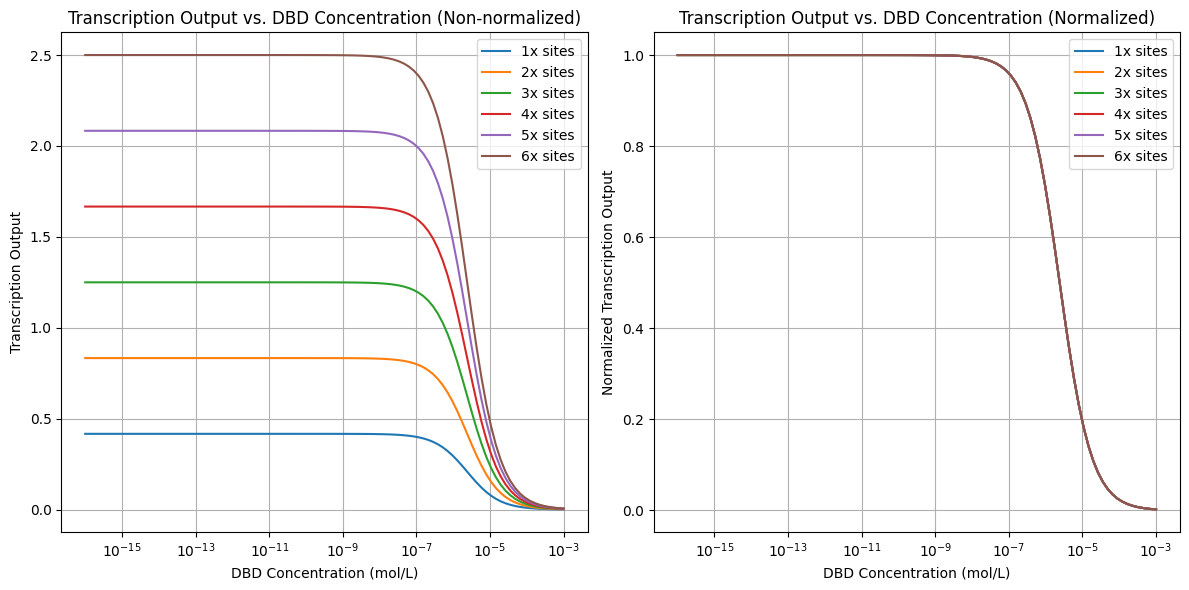

In [ ]:
#plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for sites in num_sites:
    plt.plot(DBD_concentration, outputs[sites], label=f"{sites}x sites")
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Non-normalized)')
plt.legend()
plt.grid(True)

#--
plt.subplot(1, 2, 2)
for sites in num_sites:
    plt.plot(DBD_concentration, normalized_outputs[sites], label=f"{sites}x sites")
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Normalized)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Data points (number of sites, output) for fitting the Hill function
data_points = np.array([
    [0, 1],
    [1, 10],
    [2, 200],
    [6, 800],
    [3, 570],
    [4, 730],
    [5, 780]
])


In [ ]:
# Hill function to model the cooperative effect
def hill_function(x, Kd, n, max_output):
    return max_output * (x**n / (Kd**n + x**n))

In [ ]:
# Fit the Hill function to the data points
initial_guesses = [1, 10, 800]
params, covariance = curve_fit(hill_function, data_points[:, 0], data_points[:, 1], p0=initial_guesses)
Kd, n, max_output = params

<ipython-input-10-b73c4c0eb249>:3: RuntimeWarning: divide by zero encountered in power
  return max_output * (x**n / (Kd**n + x**n))
<ipython-input-10-b73c4c0eb249>:3: RuntimeWarning: invalid value encountered in divide
  return max_output * (x**n / (Kd**n + x**n))


In [ ]:
def transcription_output(FL_conc, DBD_conc, num_sites, kD):
    prob = binding_probability(FL_conc, DBD_conc, kD)
    if num_sites == 1:
        return prob * max_output / hill_function(1, Kd, n, max_output)
    else:
        return hill_function(num_sites, Kd, n, max_output) * prob

In [ ]:
outputs = {}
normalized_outputs = {}
table_outputs = []
for sites in num_sites:
    output = transcription_output(FL_concentration, 0, sites, kD)
    outputs[sites] = transcription_output(FL_concentration, DBD_concentration, sites, kD)
    normalized_outputs[sites] = outputs[sites] / outputs[sites][0]
    table_outputs.append([sites, output])

In [ ]:
results = pd.DataFrame(table_outputs, columns=['Number of Binding Sites', 'Output'])
print(results)

   Number of Binding Sites      Output
0                        1   36.770265
1                        2   83.699793
2                        3  236.775442
3                        4  305.118921
4                        5  325.594290
5                        6  332.304631


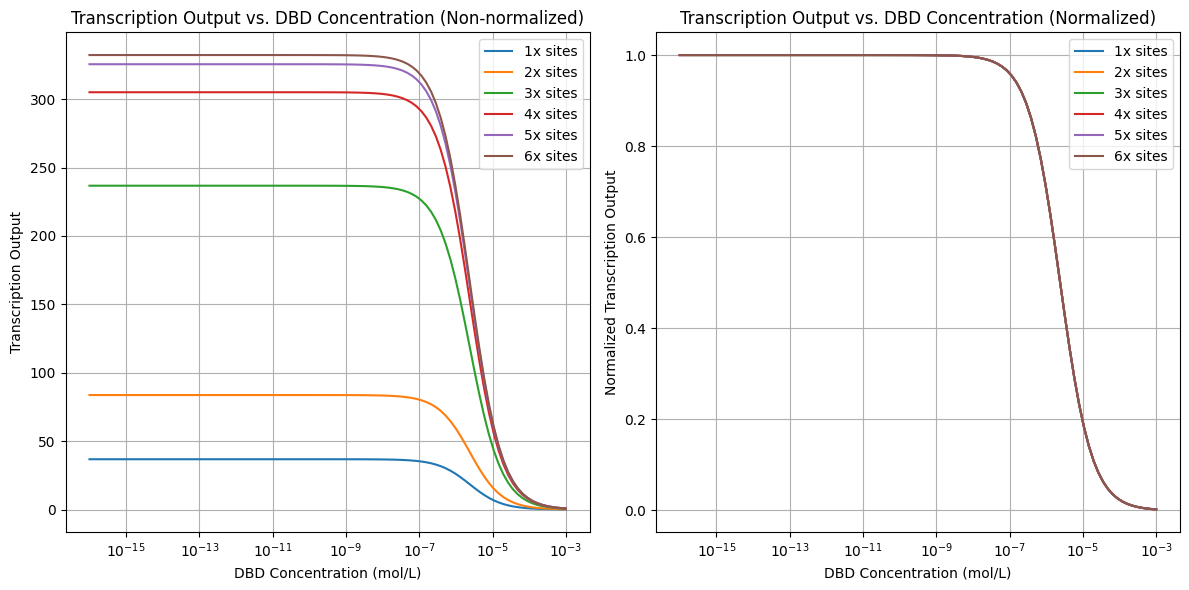

In [ ]:
# Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for sites in num_sites:
    plt.plot(DBD_concentration, outputs[sites], label=f"{sites}x sites")
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Non-normalized)')
plt.legend()
plt.grid(True)

#--
plt.subplot(1, 2, 2)
for sites in num_sites:
    plt.plot(DBD_concentration, normalized_outputs[sites], label=f"{sites}x sites")
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Normalized)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Constants
kD = 0.0000014 # Dissociation constant
FL_concentration_high = 1e-6  # FL concentration >> kD
FL_concentration_mid = 1e-9   # FL concentration ~= kD
FL_concentration_low = 1e-12  # FL concentration << kD

# DBD_concentration extended up to 1000x higher, include 0 concentration
DBD_concentration = np.concatenate(([0], np.logspace(np.log2(FL_concentration_high) - 10, np.log2(FL_concentration_high) + 3, 100, base=2)))
num_sites_list = [1, 2, 3, 4, 5, 6]

# Synergy numbers based on the provided data points
synergy_numbers = {0: 1, 1: 10, 2: 200, 3: 570, 4: 730, 5: 780, 6: 800}

In [ ]:
def binding_probability(TF1_conc, TF2_conc, kD):
    numerator = TF1_conc / kD
    denominator = 1 + (TF1_conc / kD) + (TF2_conc / kD)
    return numerator / denominator

In [ ]:
def generate_binding_states(num_sites):
    """Generate all possible binding states for a given number of binding sites."""
    states = list(itertools.product([0, 1], repeat=num_sites))
    return states

In [ ]:
# Example: Generate and print binding states for 2 binding sites
num_sites = 2
states = generate_binding_states(num_sites)

print(f"Binding states for {num_sites} binding sites:")
for state in states:
    print(state)

Binding states for 2 binding sites:
(0, 0)
(0, 1)
(1, 0)
(1, 1)


In [ ]:
def state_probability(state, FL_prob):
    """Calculate the probability of a specific binding state."""
    state_prob = 1
    for site in state:
        if site == 1:
            state_prob *= FL_prob  # FL binding probability
        else:
            state_prob *= (1 - FL_prob)  # No FL binding probability
    return state_prob

In [ ]:
def transcription_output(FL_conc, DBD_conc, num_sites, kD):
    FL_prob = binding_probability(FL_conc, DBD_conc, kD)
    states = generate_binding_states(num_sites)
    total_output = 0
    for state in states:
        num_occupied_sites = sum(state)  # Count the number of occupied sites
        state_prob = state_probability(state, FL_prob)
        total_output += state_prob * synergy_numbers[num_occupied_sites]
    return total_output

In [ ]:
def calculate_outputs(FL_conc):
    outputs = {}
    normalized_outputs = {}
    table_outputs = []

    for sites in num_sites_list:
        output = []
        for DBD_conc in DBD_concentration:
            output.append(transcription_output(FL_conc, DBD_conc, sites, kD))
        outputs[sites] = np.array(output)
        max_output = outputs[sites][0]  # Maximum output is when [DBD] = 0
        min_output = outputs[sites][-1]  # Minimum output is when [DBD] is highest

        # Print raw outputs for debugging
        print(f"Raw outputs for {sites} binding sites and FL concentration {FL_conc}: {outputs[sites]}")

        # Normalize so that it starts at 1 and tapers to 0
        normalized_outputs[sites] = (outputs[sites] - min_output) / (max_output - min_output)
        normalized_outputs[sites] = (normalized_outputs[sites] - normalized_outputs[sites][-1]) / (normalized_outputs[sites][0] - normalized_outputs[sites][-1])  # Ensure starts at 1

        # Debug statements to check normalization
        print(f"Normalized outputs for {sites} binding sites and FL concentration {FL_conc}: {normalized_outputs[sites]}")
        print(f"First value (should be 1): {normalized_outputs[sites][0]}, Last value (should be 0): {normalized_outputs[sites][-1]}")

        table_outputs.append([sites, output[0]])

    return outputs, normalized_outputs, table_outputs

In [ ]:
# Calculate outputs for different FL concentrations
outputs_high, normalized_outputs_high, table_outputs_high = calculate_outputs(FL_concentration_high)
outputs_mid, normalized_outputs_mid, table_outputs_mid = calculate_outputs(FL_concentration_mid)
outputs_low, normalized_outputs_low, table_outputs_low = calculate_outputs(FL_concentration_low)

# Convert table outputs to DataFrame
results_high = pd.DataFrame(table_outputs_high, columns=['Number of Binding Sites', 'Output'])
results_mid = pd.DataFrame(table_outputs_mid, columns=['Number of Binding Sites', 'Output'])
results_low = pd.DataFrame(table_outputs_low, columns=['Number of Binding Sites', 'Output'])

Raw outputs for 1 binding sites and FL concentration 1e-06: [4.75       4.74847474 4.74832946 4.74817036 4.7479961  4.74780526
 4.74759626 4.74736737 4.7471167  4.74684218 4.74654155 4.74621232
 4.74585179 4.74545699 4.74502466 4.74455125 4.74403286 4.74346524
 4.74284373 4.74216323 4.74141817 4.74060246 4.73970942 4.73873178
 4.73766156 4.73649007 4.73520778 4.73380431 4.73226832 4.73058741
 4.72874807 4.72673553 4.72453371 4.72212506 4.71949047 4.71660909
 4.71345827 4.71001334 4.70624746 4.70213149 4.69763379 4.69272002
 4.68735299 4.6814924  4.6750947  4.66811282 4.66049602 4.65218963
 4.64313486 4.63326865 4.62252343 4.61082698 4.59810234 4.58426769
 4.56923629 4.55291656 4.53521211 4.51602196 4.49524084 4.47275954
 4.44846552 4.42224358 4.39397677 4.36354741 4.33083846 4.29573495
 4.25812576 4.21790556 4.17497701 4.12925317 4.08066001 4.02913918
 3.97465075 3.91717603 3.85672026 3.79331515 3.72702114 3.65792928
 3.5861625  3.51187642 3.43525926 3.35653109 3.27594217 3.19377041
 3

In [ ]:
print("Results for high FL concentration:")
print(results_high)
print("\nResults for mid FL concentration:")
print(results_mid)
print("\nResults for low FL concentration:")
print(results_low)

Results for high FL concentration:
   Number of Binding Sites      Output
0                        1    4.750000
1                        2   39.923611
2                        3  106.448495
3                        4  192.527537
4                        5  285.677915
5                        6  376.501850

Results for mid FL concentration:
   Number of Binding Sites    Output
0                        1  1.006424
1                        2  1.012940
2                        3  1.019549
3                        4  1.026249
4                        5  1.033042
5                        6  1.039927

Results for low FL concentration:
   Number of Binding Sites    Output
0                        1  1.000006
1                        2  1.000013
2                        3  1.000019
3                        4  1.000026
4                        5  1.000032
5                        6  1.000039


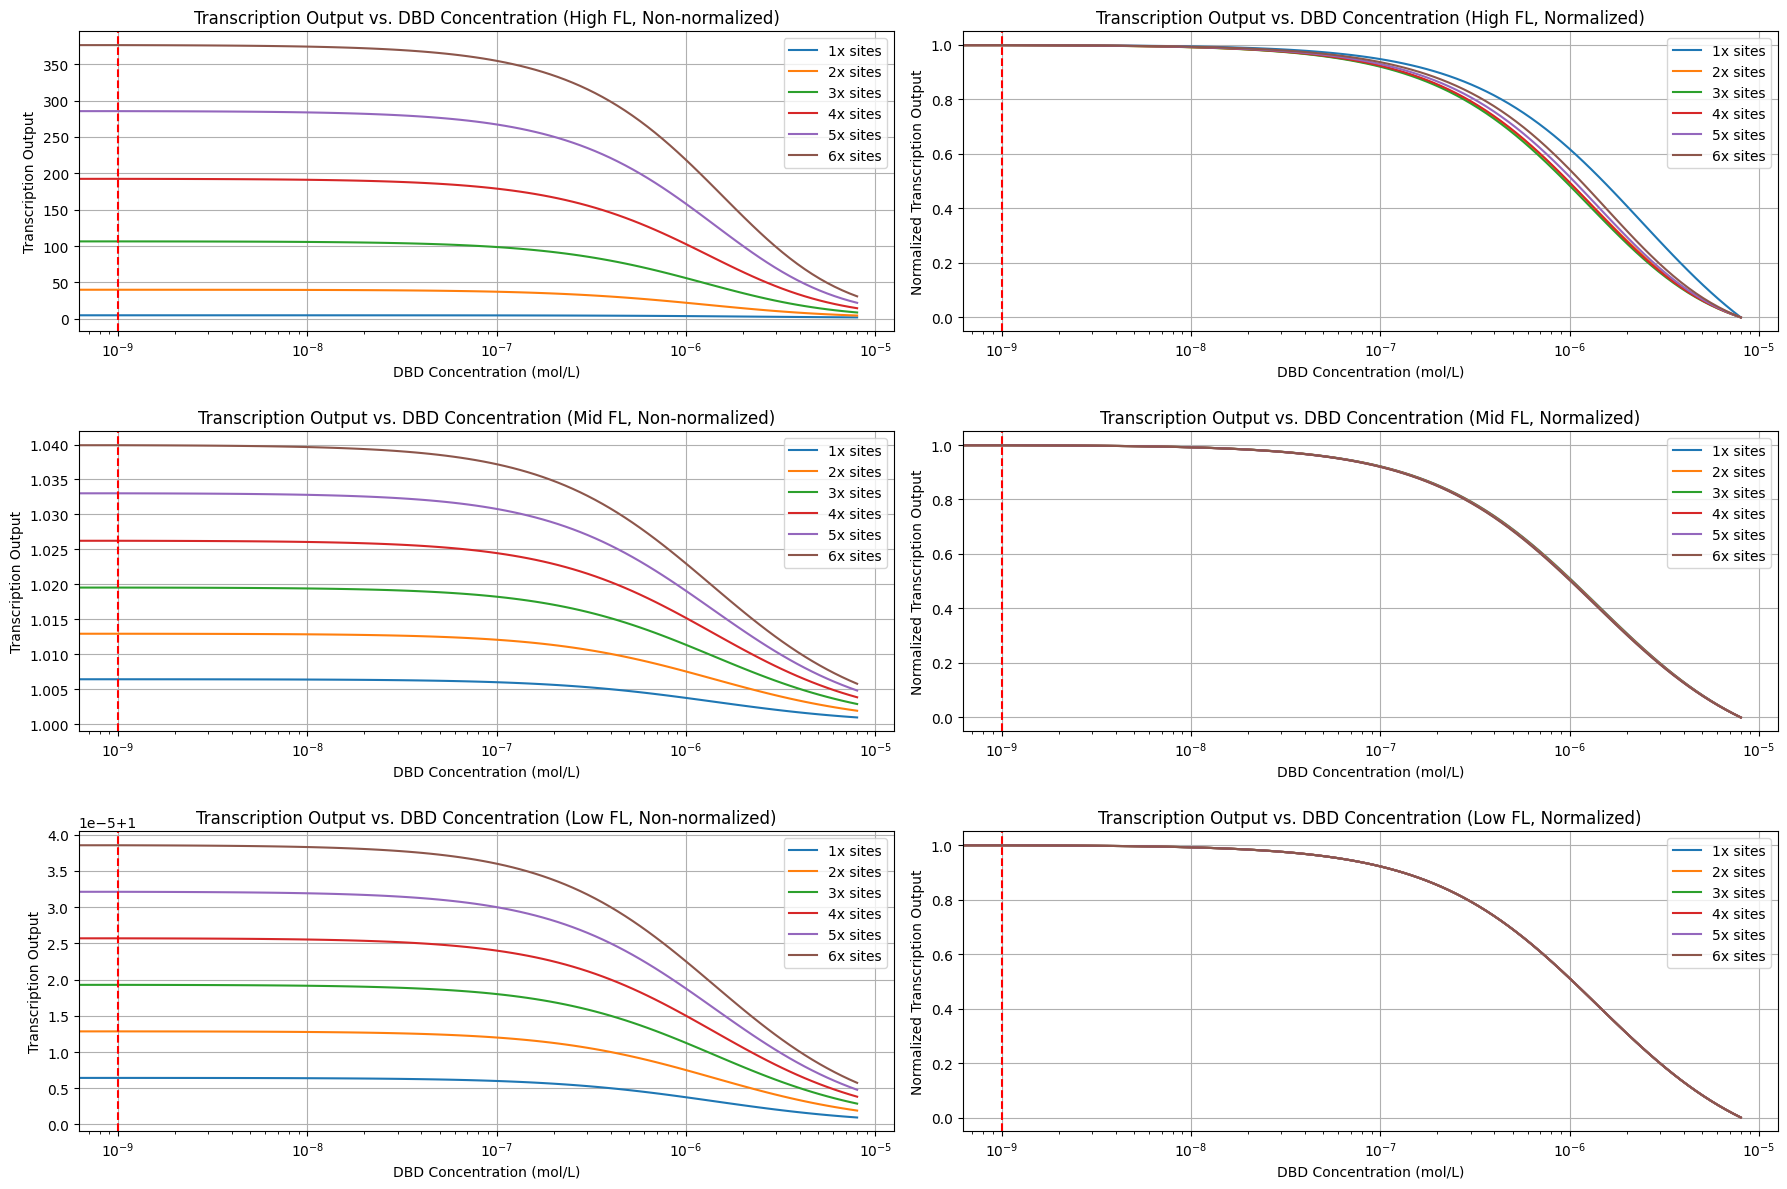

In [ ]:
# Plotting
plt.figure(figsize=(18, 12))

# Plot for high FL concentration
plt.subplot(3, 2, 1)
for sites in num_sites_list:
    plt.plot(DBD_concentration, outputs_high[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (High FL, Non-normalized)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 2)
for sites in num_sites_list:
    plt.plot(DBD_concentration, normalized_outputs_high[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (High FL, Normalized)')
plt.legend()
plt.grid(True)

# Plot for mid FL concentration
plt.subplot(3, 2, 3)
for sites in num_sites_list:
    plt.plot(DBD_concentration, outputs_mid[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Mid FL, Non-normalized)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 4)
for sites in num_sites_list:
    plt.plot(DBD_concentration, normalized_outputs_mid[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Mid FL, Normalized)')
plt.legend()
plt.grid(True)

# Plot for low FL concentration
plt.subplot(3, 2, 5)
for sites in num_sites_list:
    plt.plot(DBD_concentration, outputs_low[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Low FL, Non-normalized)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 6)
for sites in num_sites_list:
    plt.plot(DBD_concentration, normalized_outputs_low[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Low FL, Normalized)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

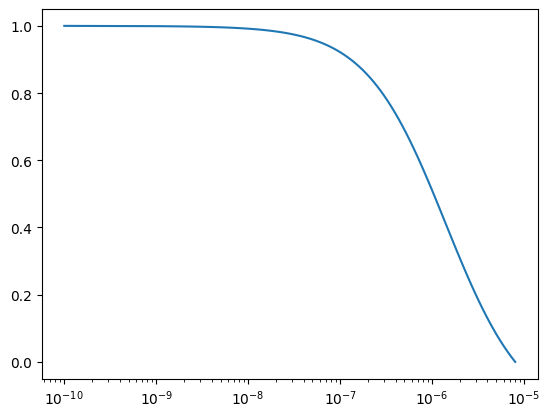

In [ ]:
DBD_concentration[0] = 1e-10

plt.plot(DBD_concentration, normalized_outputs_low[sites])
plt.xscale('log')

Raw outputs for 1 binding sites and FL concentration 1e-09: [1.00642352 1.00641951 1.00641908 1.00641862 1.0064181  1.00641754
 1.00641693 1.00641626 1.00641553 1.00641472 1.00641384 1.00641288
 1.00641182 1.00641066 1.0064094  1.00640801 1.00640649 1.00640483
 1.00640301 1.00640102 1.00639884 1.00639645 1.00639384 1.00639099
 1.00638786 1.00638444 1.0063807  1.0063766  1.00637212 1.00636722
 1.00636187 1.00635601 1.00634961 1.00634261 1.00633497 1.00632661
 1.00631749 1.00630752 1.00629665 1.00628478 1.00627183 1.0062577
 1.0062423  1.00622553 1.00620725 1.00618736 1.00616572 1.00614219
 1.00611662 1.00608886 1.00605875 1.0060261  1.00599074 1.00595249
 1.00591114 1.00586652 1.0058184  1.0057666  1.00571091 1.00565114
 1.00558709 1.00551858 1.00544545 1.00536754 1.00528472 1.0051969
 1.005104   1.00500598 1.00490285 1.00479467 1.00468152 1.00456357
 1.00444101 1.00431411 1.00418319 1.00404862 1.00391083 1.00377027
 1.00362748 1.003483   1.00333741 1.00319129 1.00304527 1.00289993
 1.0

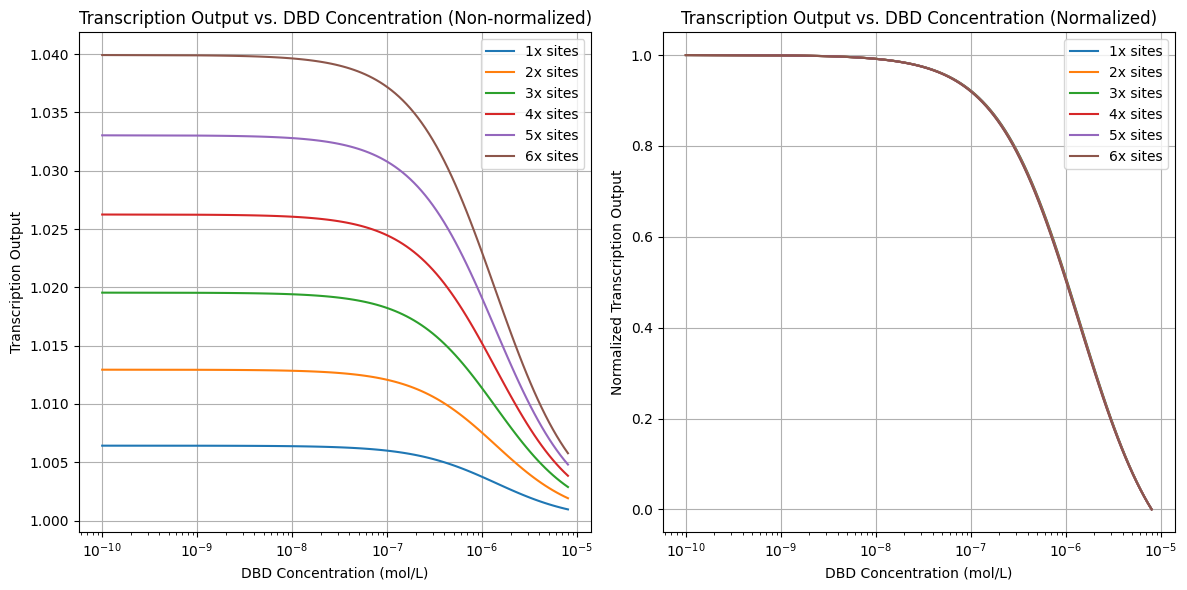

In [ ]:
FL_concentration = FL_concentration_mid  # Choose FL_concentration_high, FL_concentration_mid, or FL_concentration_low
outputs, normalized_outputs, table_outputs = calculate_outputs(FL_concentration)

# Plotting the chosen FL concentration (mid, in this case)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for sites in num_sites_list:
    plt.plot(DBD_concentration, outputs[sites], label=f"{sites}x sites")
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Non-normalized)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for sites in num_sites_list:
    plt.plot(DBD_concentration, normalized_outputs[sites], label=f"{sites}x sites")
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Normalized)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
@interact(DBD_conc=FloatLogSlider(value=1e-9, base=10, min=-10, max=3, step=0.1, description='DBD Concentration (mol/L)'))
def update(DBD_conc):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    for sites in num_sites_list:
        plt.plot(DBD_concentration, outputs[sites], label=f"{sites}x sites")
    plt.axvline(DBD_conc, color='r', linestyle='--')
    plt.xscale('log')
    plt.xlabel('DBD Concentration (mol/L)')
    plt.ylabel('Transcription Output')
    plt.title('Transcription Output vs. DBD Concentration (Non-normalized)')
    plt.legend()
    plt.grid(True)
    plt.show()


interactive(children=(FloatLogSlider(value=1e-09, description='DBD Concentration (mol/L)', max=3.0, min=-10.0)…

Raw outputs for 1 binding sites and FL concentration 0.001: [9.98741762 9.98741762 9.98741762 9.98741762 9.98741762 9.98741762
 9.98741762 9.98741762 9.98741762 9.98741762 9.98741762 9.98741762
 9.98741762 9.98741762 9.98741762 9.98741762 9.98741762 9.98741762
 9.98741762 9.98741762 9.98741762 9.98741762 9.98741762 9.98741762
 9.98741762 9.98741762 9.98741762 9.98741762 9.98741762 9.98741762
 9.98741762 9.98741762 9.98741762 9.98741761 9.98741761 9.98741761
 9.98741761 9.98741761 9.98741761 9.98741761 9.9874176  9.9874176
 9.98741759 9.98741757 9.98741755 9.9874175  9.98741744 9.98741733
 9.98741717 9.9874169  9.98741648 9.98741581 9.98741474 9.98741304
 9.98741034 9.98740602 9.98739916 9.98738823 9.98737082 9.98734311
 9.98729897 9.98722871 9.98711682 9.98693868 9.98665504 9.98620344
 9.98548446 9.98433987 9.98251797 9.97961852 9.97500563 9.96767038
 9.95601529 9.9375195  9.90822611 9.861977   9.78931831 9.67605237
 9.50160468 9.23786355 8.85009543 8.3027469  7.57299911 6.67071274
 5.

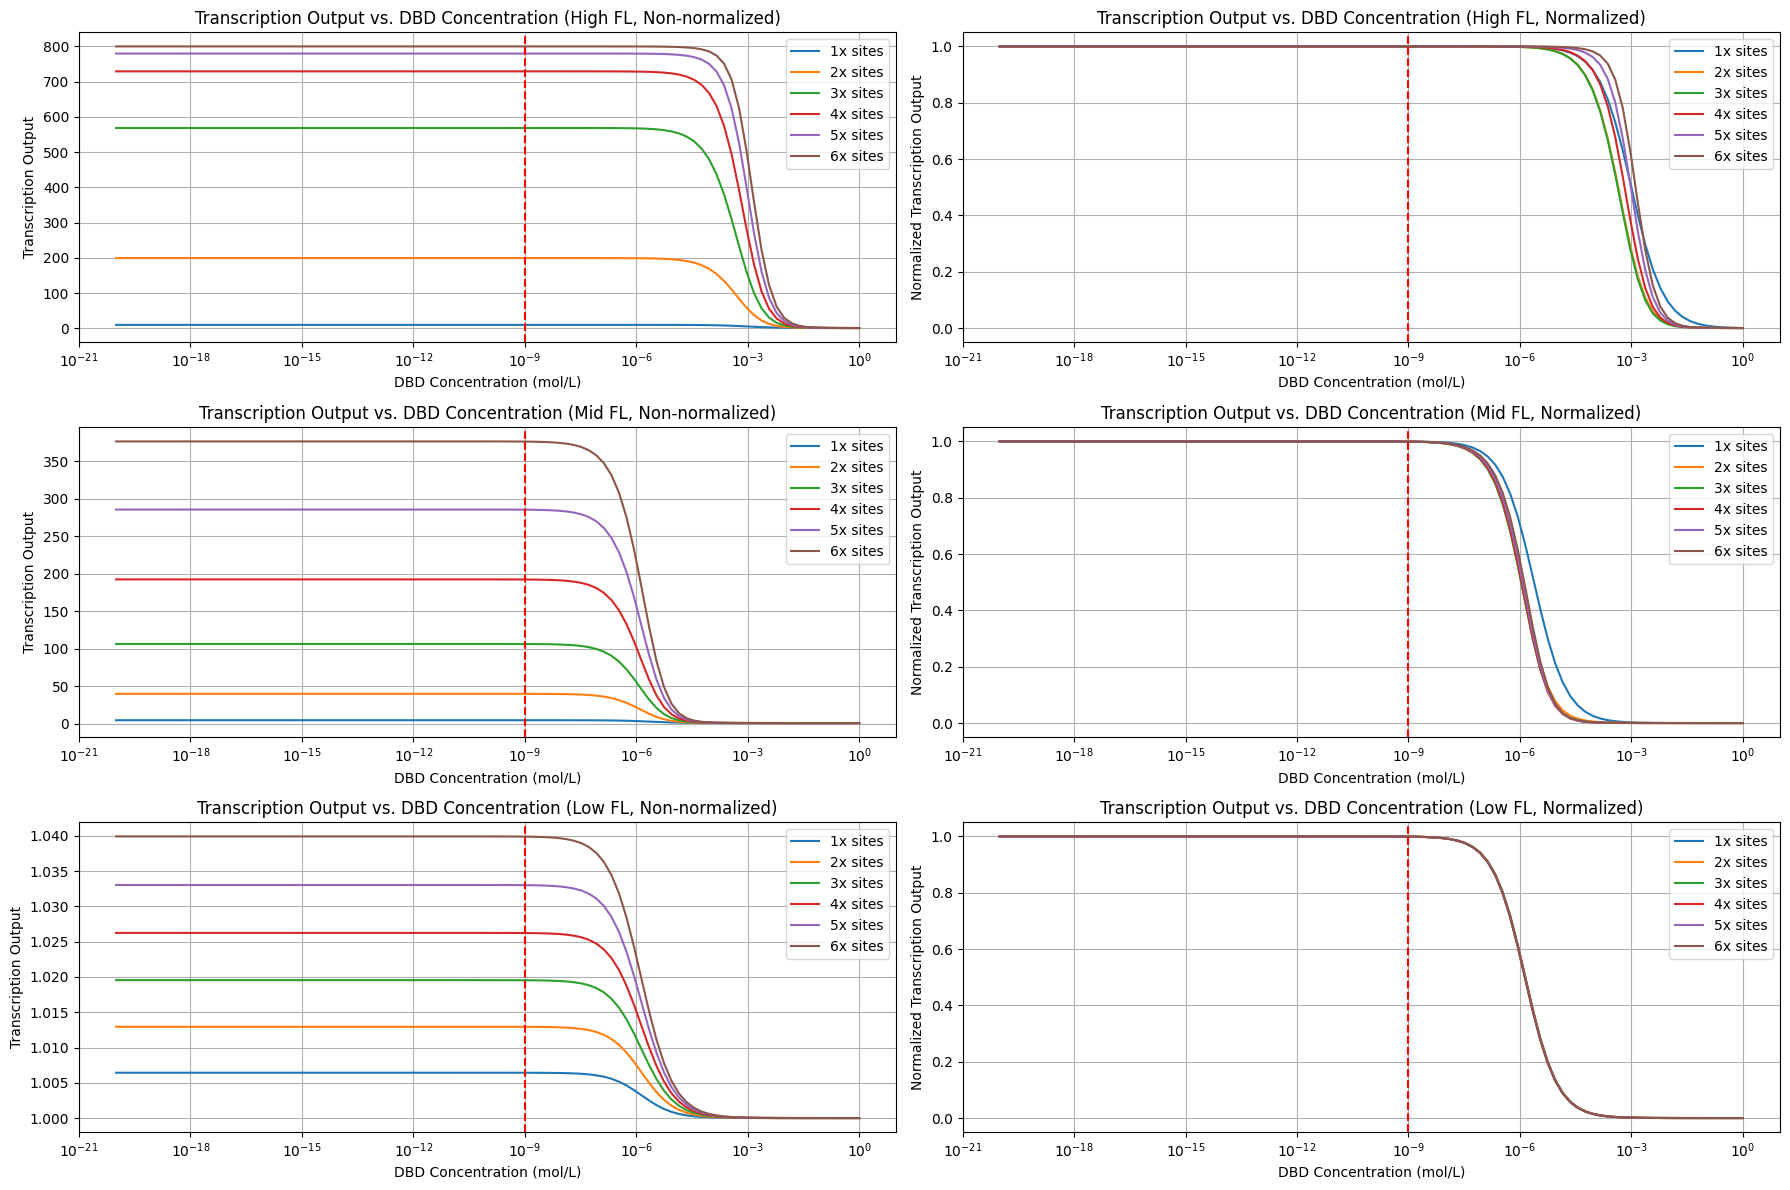

In [ ]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# Constants
kD = 0.0000014  # Dissociation constant
FL_concentration_high = 1e-3  # FL concentration >> kD
FL_concentration_mid = 1e-6   # FL concentration ~= kD
FL_concentration_low = 1e-9  # FL concentration << kD

# DBD_concentration extended up to 1000x higher, starting from 1e-10
DBD_concentration = np.logspace(np.log10(1e-20), np.log10(FL_concentration_high) + 3, 100)
num_sites_list = [1, 2, 3, 4, 5, 6]

# Synergy numbers based on the provided data points
synergy_numbers = {0: 1, 1: 10, 2: 200, 3: 570, 4: 730, 5: 780, 6: 800}

def binding_probability(TF1_conc, TF2_conc, kD):
    numerator = TF1_conc / kD
    denominator = 1 + (TF1_conc / kD) + (TF2_conc / kD)
    return numerator / denominator

def generate_binding_states(num_sites):
    """Generate all possible binding states for a given number of binding sites."""
    states = list(itertools.product([0, 1], repeat=num_sites))
    return states

def state_probability(state, FL_prob):
    """Calculate the probability of a specific binding state."""
    state_prob = 1
    for site in state:
        if site == 1:
            state_prob *= FL_prob  # FL binding probability
        else:
            state_prob *= (1 - FL_prob)  # No FL binding probability
    return state_prob

def transcription_output(FL_conc, DBD_conc, num_sites, kD):
    FL_prob = binding_probability(FL_conc, DBD_conc, kD)
    states = generate_binding_states(num_sites)
    total_output = 0
    for state in states:
        num_occupied_sites = sum(state)  # Count the number of occupied sites
        state_prob = state_probability(state, FL_prob)
        total_output += state_prob * synergy_numbers[num_occupied_sites]
    return total_output

def calculate_outputs(FL_conc):
    outputs = {}
    normalized_outputs = {}
    table_outputs = []

    for sites in num_sites_list:
        output = []
        for DBD_conc in DBD_concentration:
            output.append(transcription_output(FL_conc, DBD_conc, sites, kD))
        outputs[sites] = np.array(output)
        max_output = outputs[sites][0]  # Maximum output is when [DBD] = 0
        min_output = outputs[sites][-1]  # Minimum output is when [DBD] is highest

        # Print raw outputs for debugging
        print(f"Raw outputs for {sites} binding sites and FL concentration {FL_conc}: {outputs[sites]}")

        # Normalize so that it starts at 1 and tapers to 0
        normalized_outputs[sites] = (outputs[sites] - min_output) / (max_output - min_output)
        normalized_outputs[sites] = (normalized_outputs[sites] - normalized_outputs[sites][-1]) / (normalized_outputs[sites][0] - normalized_outputs[sites][-1])  # Ensure starts at 1

        # Debug statements to check normalization
        print(f"Normalized outputs for {sites} binding sites and FL concentration {FL_conc}: {normalized_outputs[sites]}")
        print(f"First value (should be 1): {normalized_outputs[sites][0]}, Last value (should be 0): {normalized_outputs[sites][-1]}")

        table_outputs.append([sites, output[0]])

    return outputs, normalized_outputs, table_outputs

# Calculate outputs for different FL concentrations
outputs_high, normalized_outputs_high, table_outputs_high = calculate_outputs(FL_concentration_high)
outputs_mid, normalized_outputs_mid, table_outputs_mid = calculate_outputs(FL_concentration_mid)
outputs_low, normalized_outputs_low, table_outputs_low = calculate_outputs(FL_concentration_low)

# Convert table outputs to DataFrame
results_high = pd.DataFrame(table_outputs_high, columns=['Number of Binding Sites', 'Output'])
results_mid = pd.DataFrame(table_outputs_mid, columns=['Number of Binding Sites', 'Output'])
results_low = pd.DataFrame(table_outputs_low, columns=['Number of Binding Sites', 'Output'])
print("Results for high FL concentration:")
print(results_high)
print("\nResults for mid FL concentration:")
print(results_mid)
print("\nResults for low FL concentration:")
print(results_low)

# Plotting
plt.figure(figsize=(18, 12))

# Plot for high FL concentration
plt.subplot(3, 2, 1)
for sites in num_sites_list:
    plt.plot(DBD_concentration, outputs_high[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (High FL, Non-normalized)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 2)
for sites in num_sites_list:
    plt.plot(DBD_concentration, normalized_outputs_high[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (High FL, Normalized)')
plt.legend()
plt.grid(True)

# Plot for mid FL concentration
plt.subplot(3, 2, 3)
for sites in num_sites_list:
    plt.plot(DBD_concentration, outputs_mid[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Mid FL, Non-normalized)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 4)
for sites in num_sites_list:
    plt.plot(DBD_concentration, normalized_outputs_mid[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Mid FL, Normalized)')
plt.legend()
plt.grid(True)

# Plot for low FL concentration
plt.subplot(3, 2, 5)
for sites in num_sites_list:
    plt.plot(DBD_concentration, outputs_low[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Low FL, Non-normalized)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 6)
for sites in num_sites_list:
    plt.plot(DBD_concentration, normalized_outputs_low[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Low FL, Normalized)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


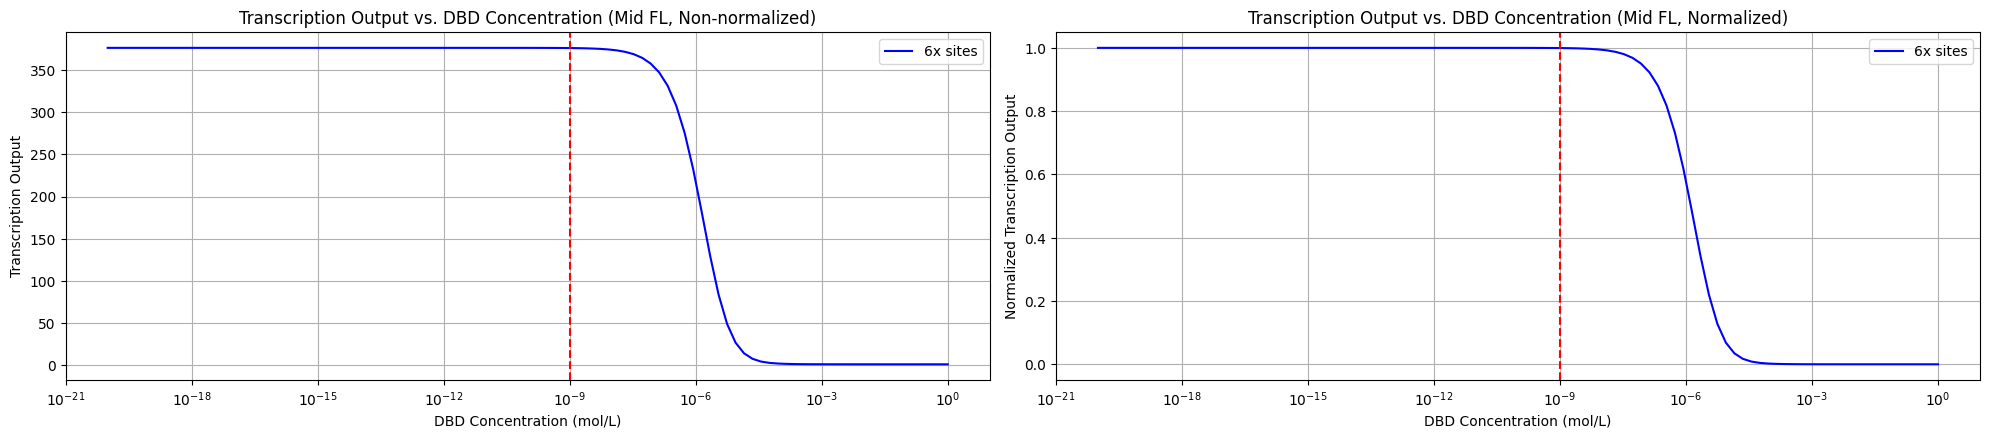

In [ ]:
plt.figure(figsize=(20, 12))  # Large figure size for better visibility

# Plot for mid FL concentration (Non-normalized) - 6x line only
plt.subplot(3, 2, 3)
plt.plot(DBD_concentration, outputs_mid[6], label="6x sites", color='blue')
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Mid FL, Non-normalized)')
plt.legend()
plt.grid(True)

# Plot for mid FL concentration (Normalized) - 6x line only
plt.subplot(3, 2, 4)
plt.plot(DBD_concentration, normalized_outputs_mid[6], label="6x sites", color='blue')
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Mid FL, Normalized)')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


Raw outputs for 1 binding sites and FL concentration 1.3e-05: [9.125      9.125      9.125      9.125      9.125      9.125
 9.125      9.125      9.125      9.125      9.125      9.125
 9.125      9.125      9.125      9.125      9.125      9.125
 9.125      9.125      9.125      9.125      9.125      9.125
 9.125      9.125      9.125      9.125      9.125      9.125
 9.12499999 9.12499999 9.12499998 9.12499997 9.12499996 9.12499993
 9.12499989 9.12499983 9.12499973 9.12499957 9.12499932 9.12499892
 9.12499828 9.12499726 9.12499563 9.12499304 9.12498892 9.12498236
 9.12497192 9.12495529 9.1249288  9.12488663 9.12481949 9.12471258
 9.12454236 9.12427133 9.12383981 9.1231528  9.12205913 9.12031831
 9.11754797 9.11314071 9.10613296 9.0949996  9.07733512 9.04936682
 9.00523092 8.93594435 8.82806218 8.66220846 8.41215345 8.04601498
 7.53222866 6.85268926 6.02099573 5.09452521 4.16471128 3.32428151
 2.63353804 2.10883368 1.73362107 1.47674742 1.30609203 1.19496683
 1.12354761 1.07803286 1.

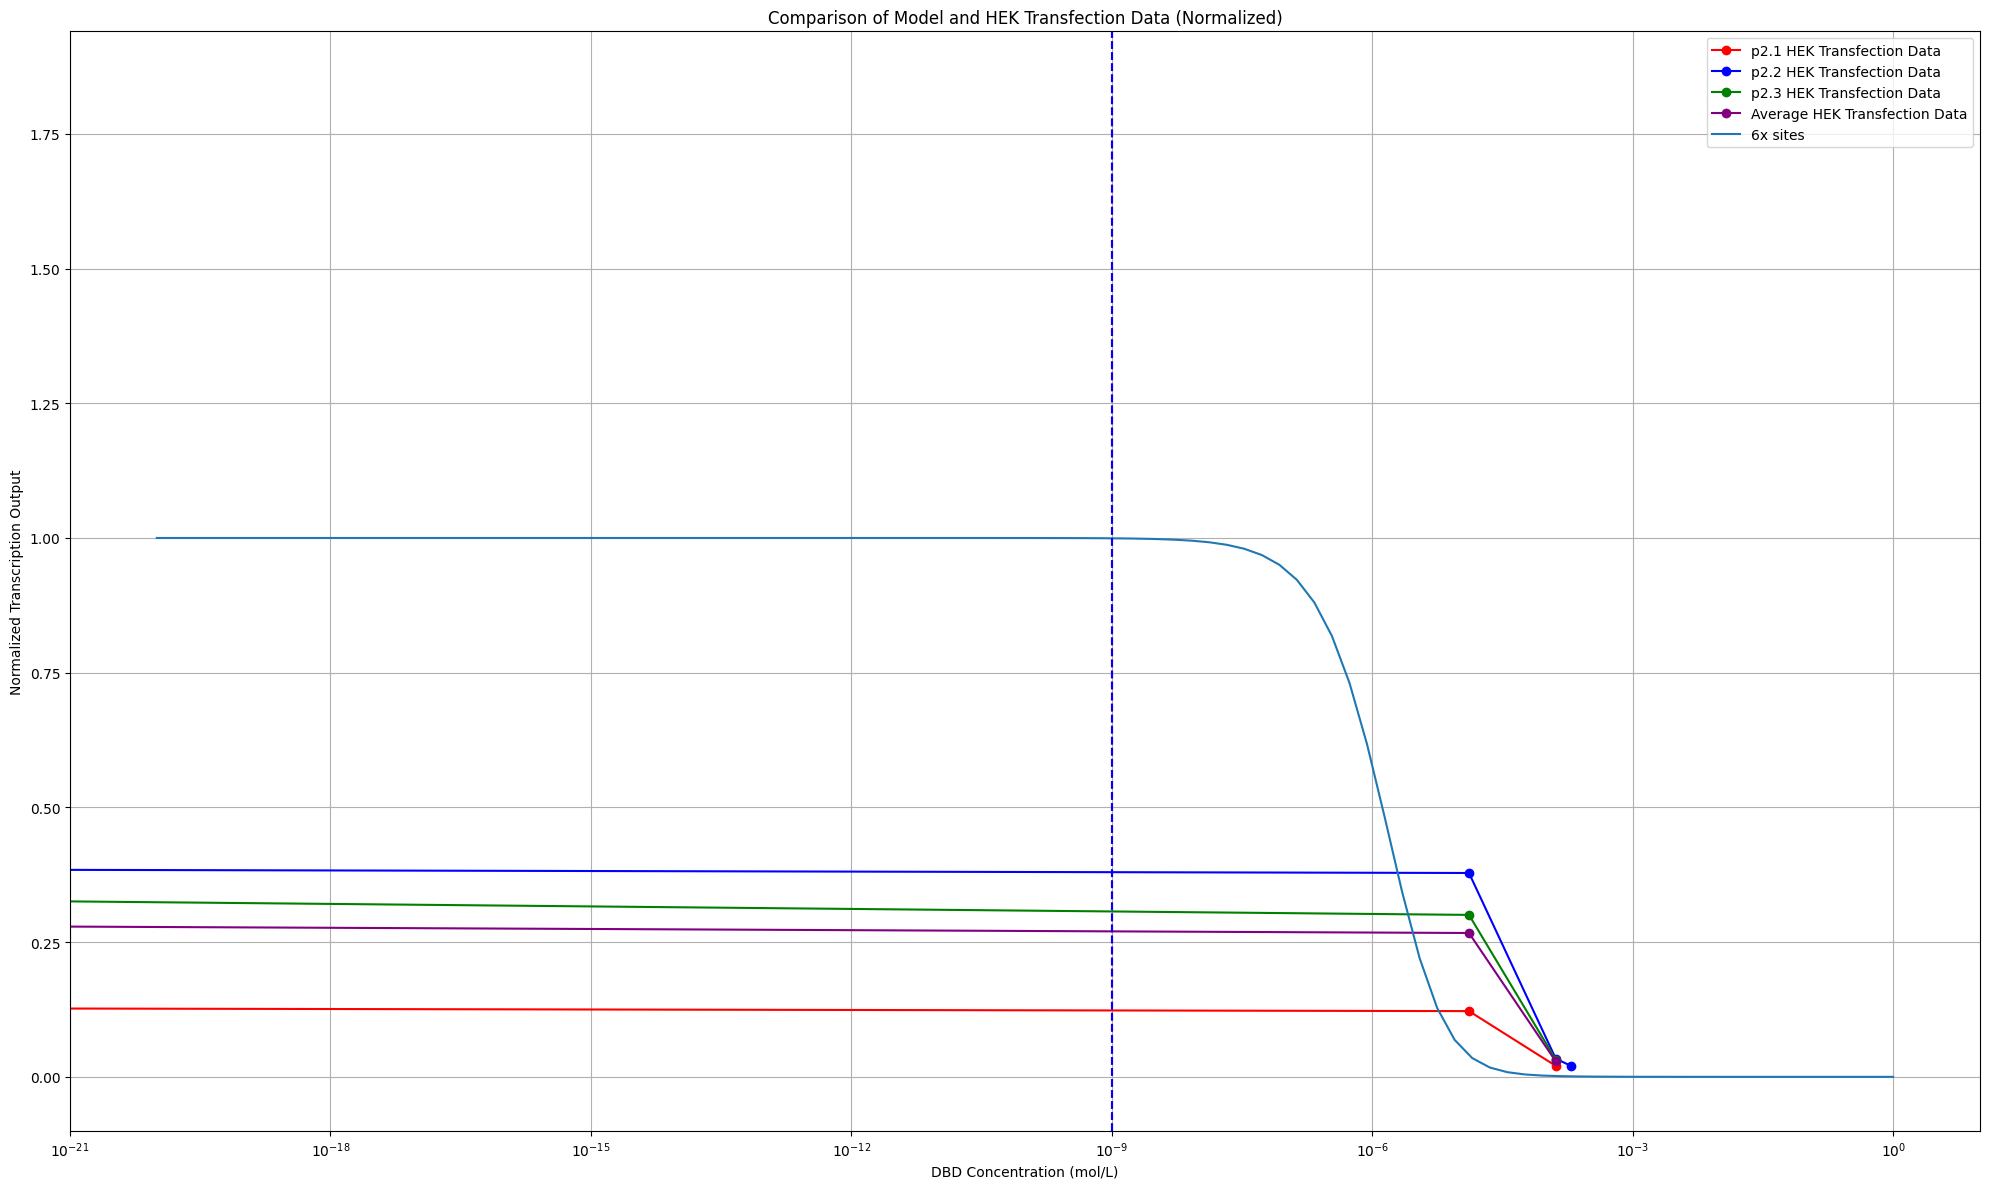

In [ ]:

# Given data
FL_concentration = 0.000013 # placeholder value

p21_data = {
    'dbd': [0, 0, 1, 10],
    'p21_data': [9, 472, 138, 23], #how do we convert this data to the transcriptional output?
}

p22_data = {
    'dbd': [0, 0, 1, 10, 15],
    'p22_data': [42, 832, 428, 38, 23],
}

p23_data = {
    'dbd': [0, 0, 1, 10],
    'p23_data': [-9, 2090, 340, 36],
}

avg_data = {
    'dbd': [0, 0, 1, 10],
    'avg_data': [14, 1131.3, 302, 32.3],
}

# Convert to DataFrames
df_p21 = pd.DataFrame(p21_data)
df_p22 = pd.DataFrame(p22_data)
df_p23 = pd.DataFrame(p23_data)
df_avg = pd.DataFrame(avg_data)

# Normalize the data by dividing by 1131.3 (max activation = 1)
df_p21['p21_normalized'] = df_p21['p21_data'] / 1131.3
df_p22['p22_normalized'] = df_p22['p22_data'] / 1131.3
df_p23['p23_normalized'] = df_p23['p23_data'] / 1131.3
df_avg['avg_normalized'] = df_avg['avg_data'] / 1131.3

# Corresponding DBD concentrations for the ratios in the data
df_p21['dbd_conc'] = df_p21['dbd'] * FL_concentration
df_p22['dbd_conc'] = df_p22['dbd'] * FL_concentration
df_p23['dbd_conc'] = df_p23['dbd'] * FL_concentration
df_avg['dbd_conc'] = df_avg['dbd'] * FL_concentration

# Plotting the data along with the model
plt.figure(figsize=(20, 12))

# Plot the normalized data as a line with markers
plt.plot(df_p21['dbd_conc'], df_p21['p21_normalized'], 'o-', color='red', label="p2.1 HEK Transfection Data")
plt.plot(df_p22['dbd_conc'], df_p22['p22_normalized'], 'o-', color='blue', label="p2.2 HEK Transfection Data")
plt.plot(df_p23['dbd_conc'], df_p23['p23_normalized'], 'o-', color='green', label="p2.3 HEK Transfection Data")
plt.plot(df_avg['dbd_conc'], df_avg['avg_normalized'], 'o-', color='purple', label="Average HEK Transfection Data")

# Adding a vertical line at 1e-9 for reference
plt.axvline(1e-9, color='r', linestyle='--')

# Set x-axis to log scale
plt.xscale('log')

#MODEL PLOT
plt.plot(DBD_concentration, normalized_outputs_mid[6], label=f"{sites}x sites")
plt.axvline(1e-9, color='b', linestyle='--')
outputs_mid, normalized_outputs_mid, table_outputs_mid = calculate_outputs(FL_concentration)
results_mid = pd.DataFrame(table_outputs_mid, columns=['Number of Binding Sites', 'Output'])

# Labels and title
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Comparison of Model and HEK Transfection Data (Normalized)')
plt.legend()
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


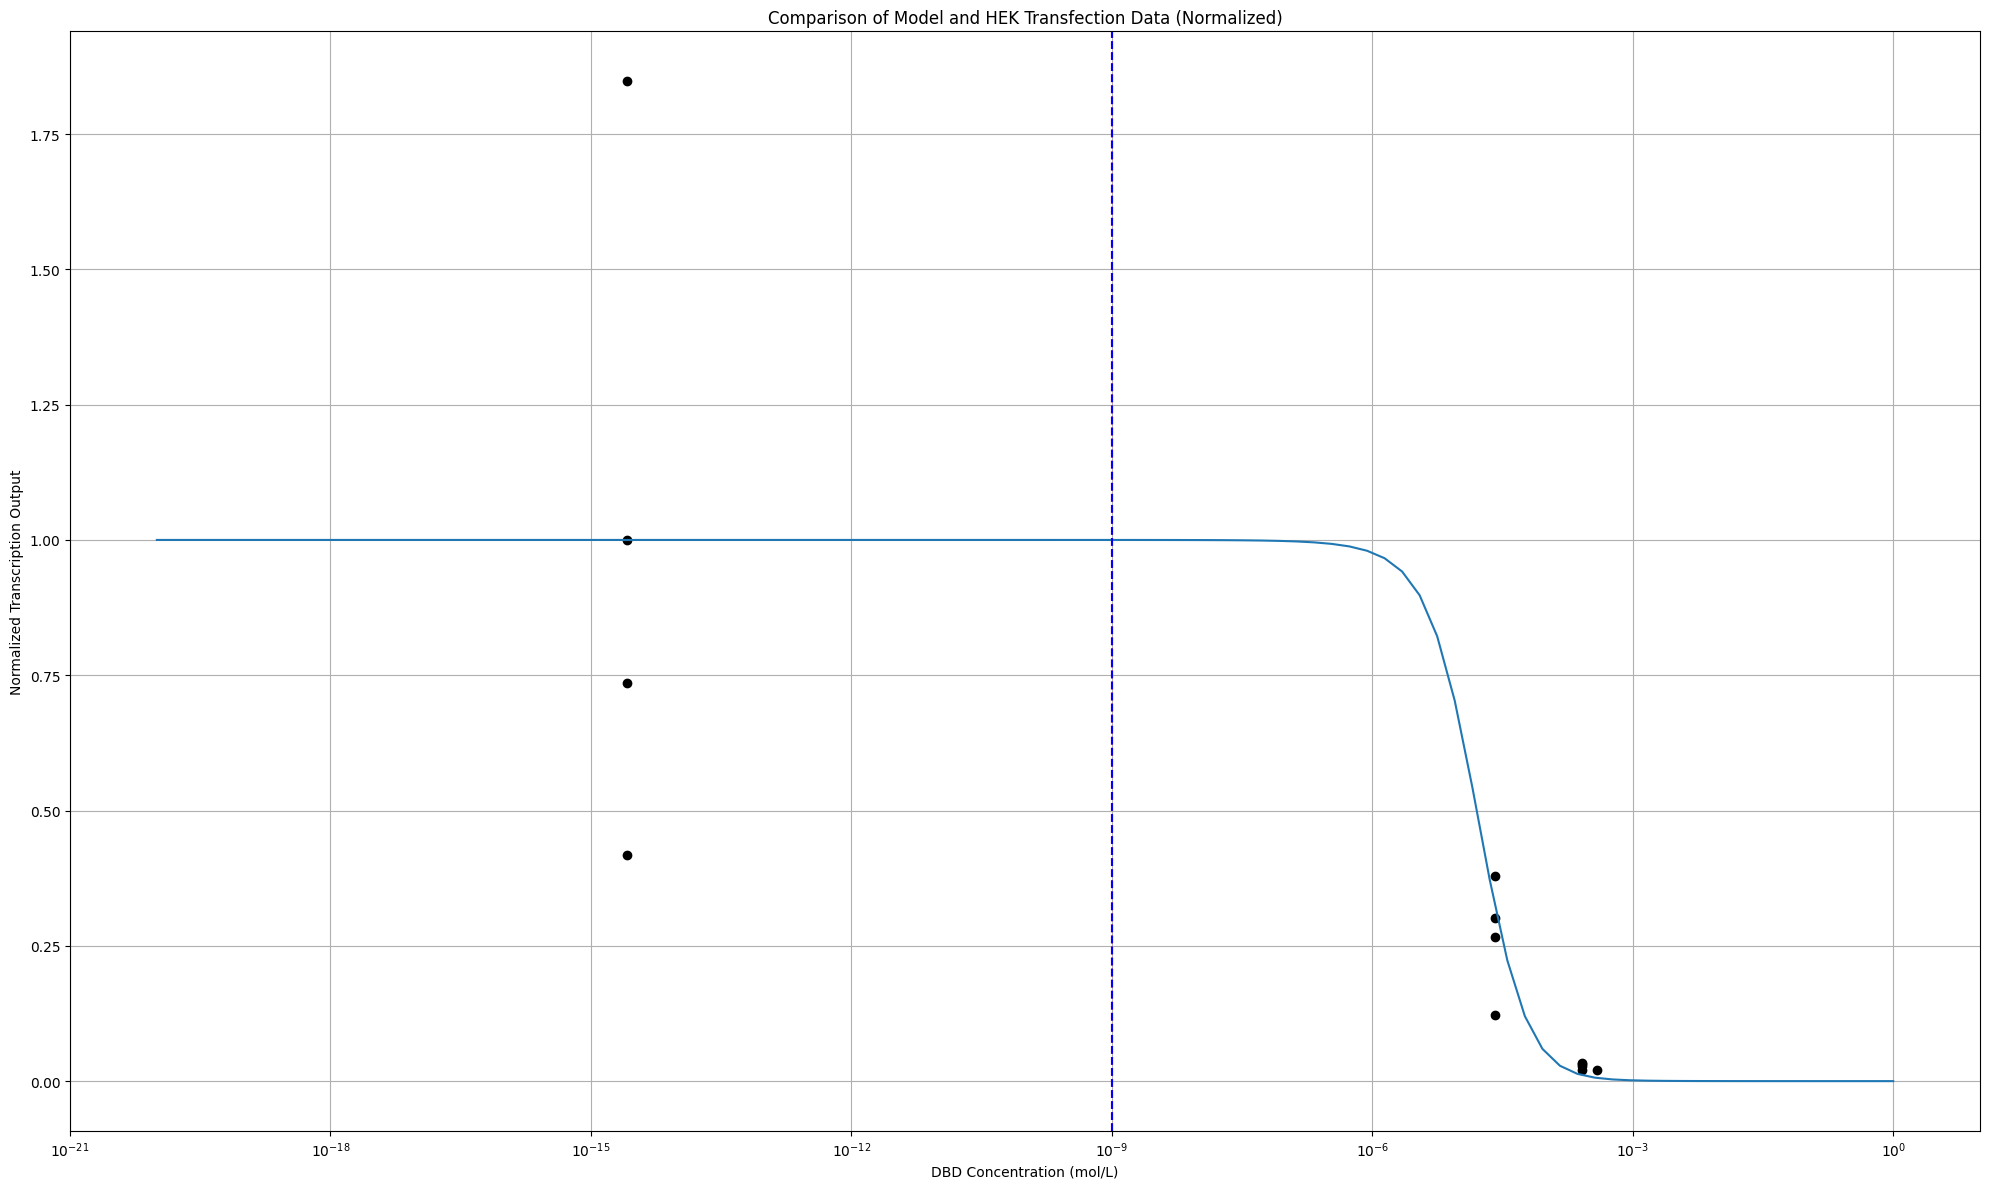

In [ ]:
# Given data
FL_concentration = 0.000013

p21_data = {
    'dbd': [1e-10, 1, 10],
    'p21_data': [472, 138, 23],
}

p22_data = {
    'dbd': [1e-10, 1, 10, 15],
    'p22_data': [832, 428, 38, 23],
}

p23_data = {
    'dbd': [1e-10, 1, 10],
    'p23_data': [2090, 340, 36],
}

avg_data = {
    'dbd': [1e-10, 1, 10],
    'avg_data': [1131.3, 302, 32.3],
}

# Convert to DataFrames
df_p21 = pd.DataFrame(p21_data)
df_p22 = pd.DataFrame(p22_data)
df_p23 = pd.DataFrame(p23_data)
df_avg = pd.DataFrame(avg_data)

# Normalize the data by dividing by 1131.3 (max activation = 1)
df_p21['p21_normalized'] = df_p21['p21_data'] / 1131.3
df_p22['p22_normalized'] = df_p22['p22_data'] / 1131.3
df_p23['p23_normalized'] = df_p23['p23_data'] / 1131.3
df_avg['avg_normalized'] = df_avg['avg_data'] / 1131.3

# Corresponding DBD concentrations for the ratios in the data, because of the different promoters
df_p21['dbd_conc'] = df_p21['dbd'] * FL_concentration * 2
df_p22['dbd_conc'] = df_p22['dbd'] * FL_concentration * 2
df_p23['dbd_conc'] = df_p23['dbd'] * FL_concentration * 2
df_avg['dbd_conc'] = df_avg['dbd'] * FL_concentration * 2

# Plotting the data along with the model
plt.figure(figsize=(20, 12))

# Plot the normalized data as points with the same color
plt.scatter(df_p21['dbd_conc'], df_p21['p21_normalized'], color='black')
plt.scatter(df_p22['dbd_conc'], df_p22['p22_normalized'], color='black')
plt.scatter(df_p23['dbd_conc'], df_p23['p23_normalized'], color='black')
plt.scatter(df_avg['dbd_conc'], df_avg['avg_normalized'], color='black')

# Adding a vertical line at 1e-9 for reference
plt.axvline(1e-9, color='r', linestyle='--')

# Set x-axis to log scale
plt.xscale('log')

#MODEL PLOT
# Assuming DBD_concentration and normalized_outputs_mid are already defined elsewhere in your code
plt.plot(DBD_concentration, normalized_outputs_mid[6], label=f"{sites}x sites")
plt.axvline(1e-9, color='b', linestyle='--')

# Labels and title
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Comparison of Model and HEK Transfection Data (Normalized)')
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

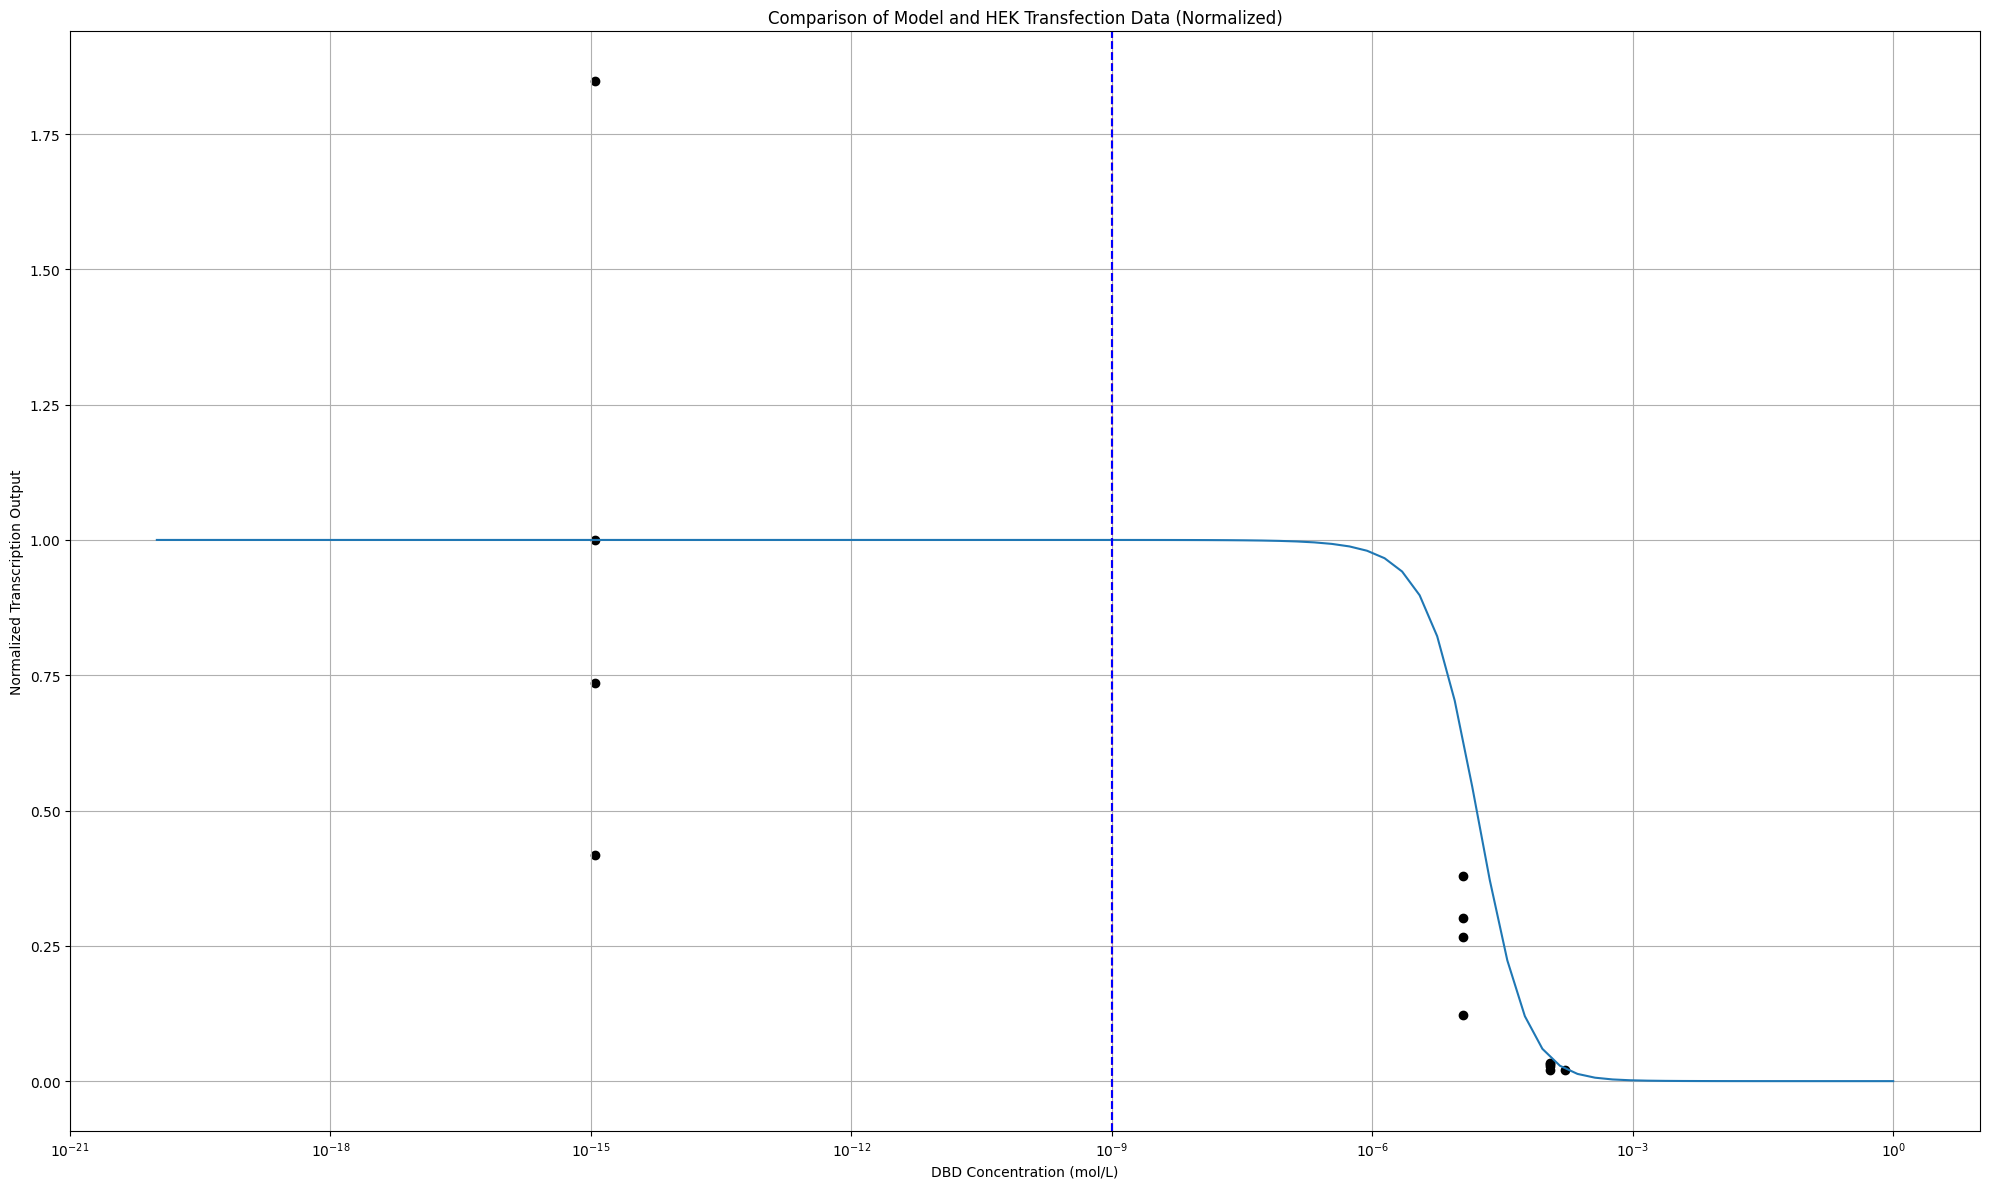

In [ ]:
# Given data
FL_concentration = 0.0000056

p21_data = {
    'dbd': [1e-10, 1, 10],
    'p21_data': [472, 138, 23],
}

p22_data = {
    'dbd': [1e-10, 1, 10, 15],
    'p22_data': [832, 428, 38, 23],
}

p23_data = {
    'dbd': [1e-10, 1, 10],
    'p23_data': [2090, 340, 36],
}

avg_data = {
    'dbd': [1e-10, 1, 10],
    'avg_data': [1131.3, 302, 32.3],
}

# Convert to DataFrames
df_p21 = pd.DataFrame(p21_data)
df_p22 = pd.DataFrame(p22_data)
df_p23 = pd.DataFrame(p23_data)
df_avg = pd.DataFrame(avg_data)

# Normalize the data by dividing by 1131.3 (max activation = 1)
df_p21['p21_normalized'] = df_p21['p21_data'] / 1131.3
df_p22['p22_normalized'] = df_p22['p22_data'] / 1131.3
df_p23['p23_normalized'] = df_p23['p23_data'] / 1131.3
df_avg['avg_normalized'] = df_avg['avg_data'] / 1131.3

# Corresponding DBD concentrations for the ratios in the data, because of the different promoters
df_p21['dbd_conc'] = df_p21['dbd'] * FL_concentration * 2
df_p22['dbd_conc'] = df_p22['dbd'] * FL_concentration * 2
df_p23['dbd_conc'] = df_p23['dbd'] * FL_concentration * 2
df_avg['dbd_conc'] = df_avg['dbd'] * FL_concentration * 2

# Plotting the data along with the model
plt.figure(figsize=(20, 12))

# Plot the normalized data as points with the same color
plt.scatter(df_p21['dbd_conc'], df_p21['p21_normalized'], color='black')
plt.scatter(df_p22['dbd_conc'], df_p22['p22_normalized'], color='black')
plt.scatter(df_p23['dbd_conc'], df_p23['p23_normalized'], color='black')
plt.scatter(df_avg['dbd_conc'], df_avg['avg_normalized'], color='black')

# Adding a vertical line at 1e-9 for reference
plt.axvline(1e-9, color='r', linestyle='--')

# Set x-axis to log scale
plt.xscale('log')

#MODEL PLOT
# Assuming DBD_concentration and normalized_outputs_mid are already defined elsewhere in your code
plt.plot(DBD_concentration, normalized_outputs_mid[6], label=f"{sites}x sites")
plt.axvline(1e-9, color='b', linestyle='--')

# Labels and title
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Comparison of Model and HEK Transfection Data (Normalized)')
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

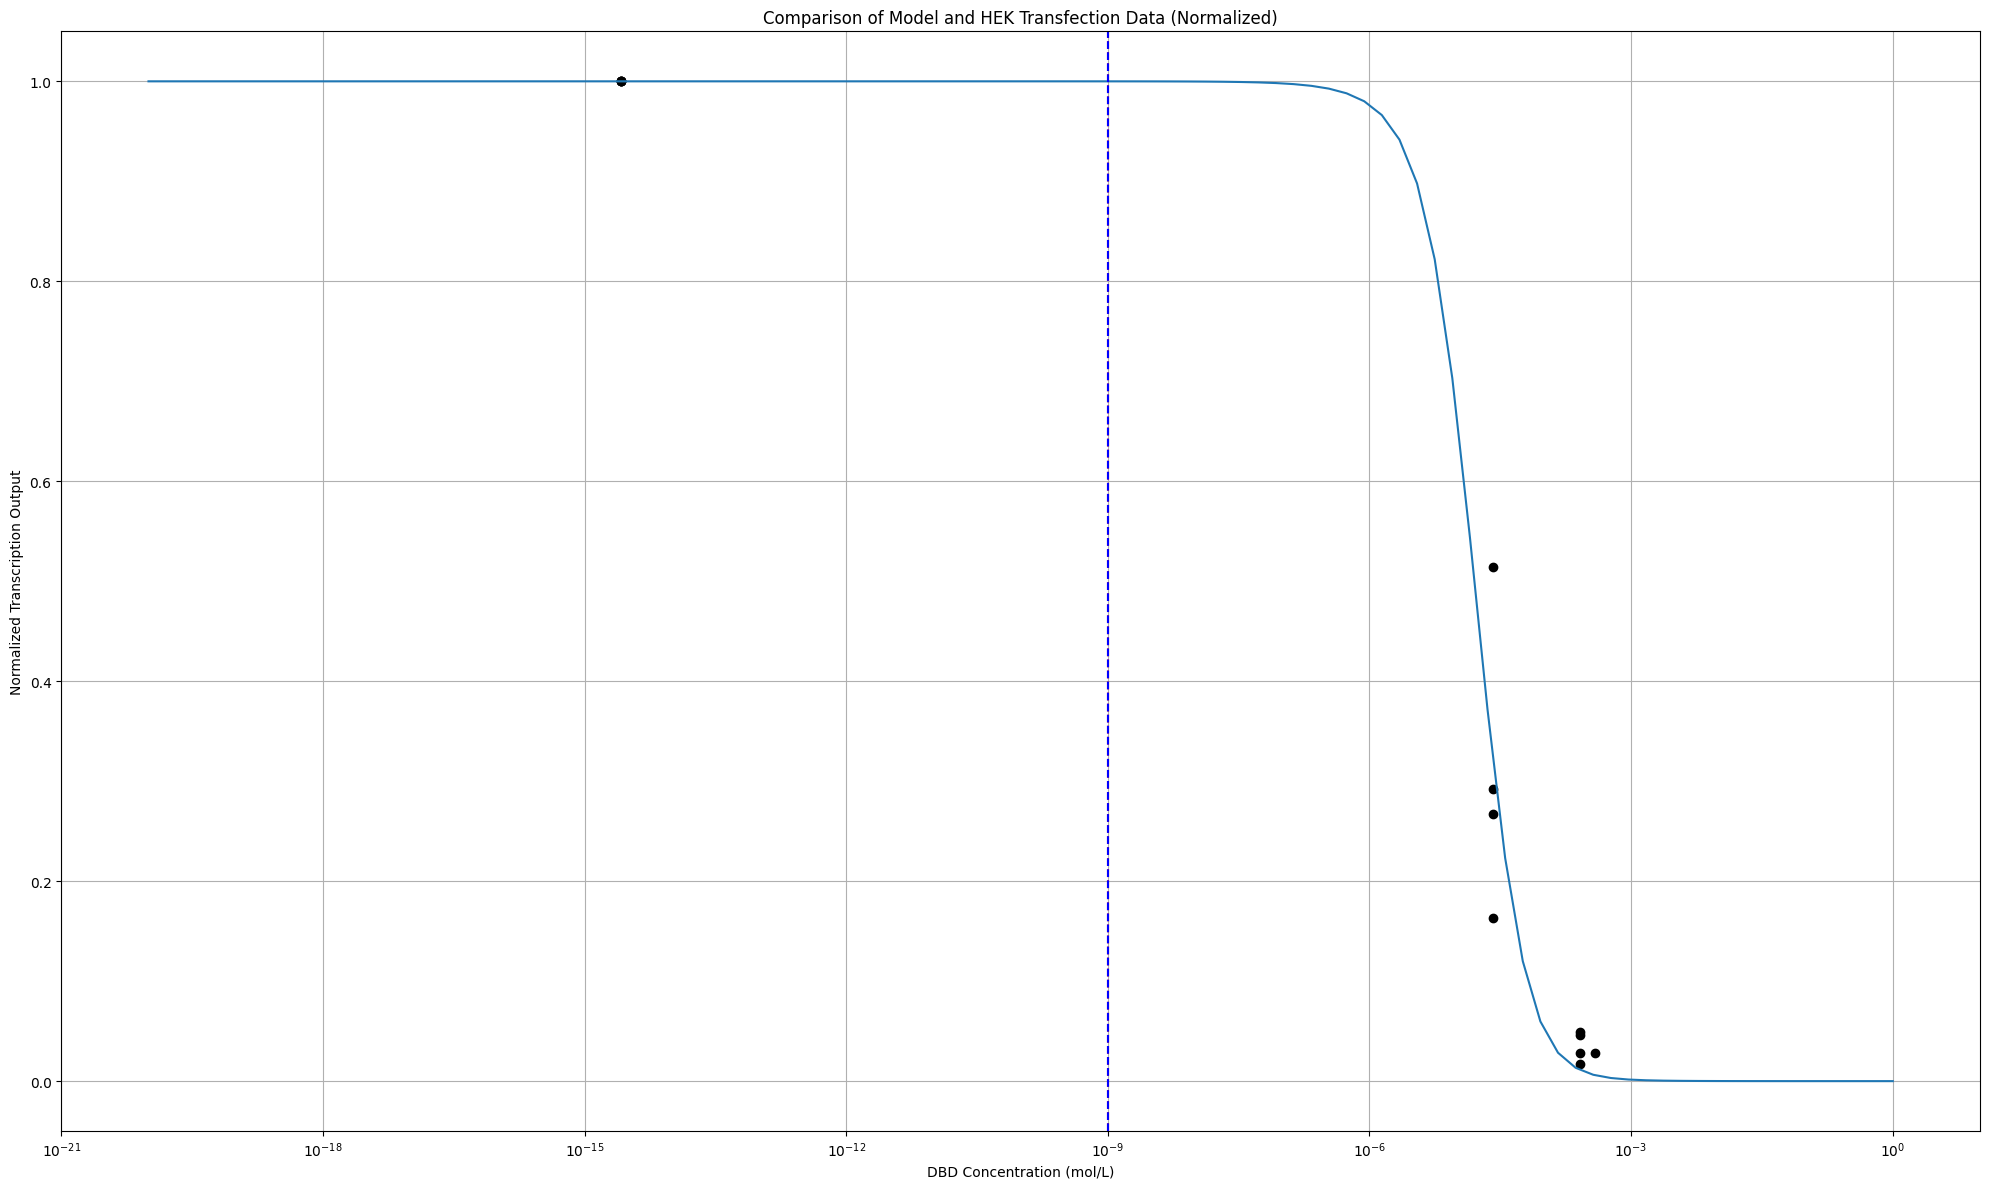

In [ ]:
# Given data
#FL_concentration = 0.000013
FL_concentration = 0.000013

p21_data = {
    'dbd': [1e-10, 1, 10],
    'p21_data': [472, 138, 23],
}

p22_data = {
    'dbd': [1e-10, 1, 10, 15],
    'p22_data': [832, 428, 38, 23],
}

p23_data = {
    'dbd': [1e-10, 1, 10],
    'p23_data': [2090, 340, 36],
}

avg_data = {
    'dbd': [1e-10, 1, 10],
    'avg_data': [1131.3, 302, 32.3],
}

# Convert to DataFrames
df_p21 = pd.DataFrame(p21_data)
df_p22 = pd.DataFrame(p22_data)
df_p23 = pd.DataFrame(p23_data)
df_avg = pd.DataFrame(avg_data)

# Normalize the data by dividing by 1131.3 (max activation = 1)
df_p21['p21_normalized'] = df_p21['p21_data'] / 472
df_p22['p22_normalized'] = df_p22['p22_data'] / 832
df_p23['p23_normalized'] = df_p23['p23_data'] / 2090
df_avg['avg_normalized'] = df_avg['avg_data'] / 1131.3

# Corresponding DBD concentrations for the ratios in the data, because of the different promoters
df_p21['dbd_conc'] = df_p21['dbd'] * FL_concentration * 2
df_p22['dbd_conc'] = df_p22['dbd'] * FL_concentration * 2
df_p23['dbd_conc'] = df_p23['dbd'] * FL_concentration * 2
df_avg['dbd_conc'] = df_avg['dbd'] * FL_concentration * 2

# Plotting the data along with the model
plt.figure(figsize=(20, 12))

# Plot the normalized data as points with the same color
plt.scatter(df_p21['dbd_conc'], df_p21['p21_normalized'], color='black')
plt.scatter(df_p22['dbd_conc'], df_p22['p22_normalized'], color='black')
plt.scatter(df_p23['dbd_conc'], df_p23['p23_normalized'], color='black')
plt.scatter(df_avg['dbd_conc'], df_avg['avg_normalized'], color='black')

# Adding a vertical line at 1e-9 for reference
plt.axvline(1e-9, color='r', linestyle='--')

# Set x-axis to log scale
plt.xscale('log')

#MODEL PLOT
# Assuming DBD_concentration and normalized_outputs_mid are already defined elsewhere in your code
plt.plot(DBD_concentration, normalized_outputs_mid[6], label=f"{sites}x sites")
plt.axvline(1e-9, color='b', linestyle='--')

# Labels and title
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Comparison of Model and HEK Transfection Data (Normalized)')
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

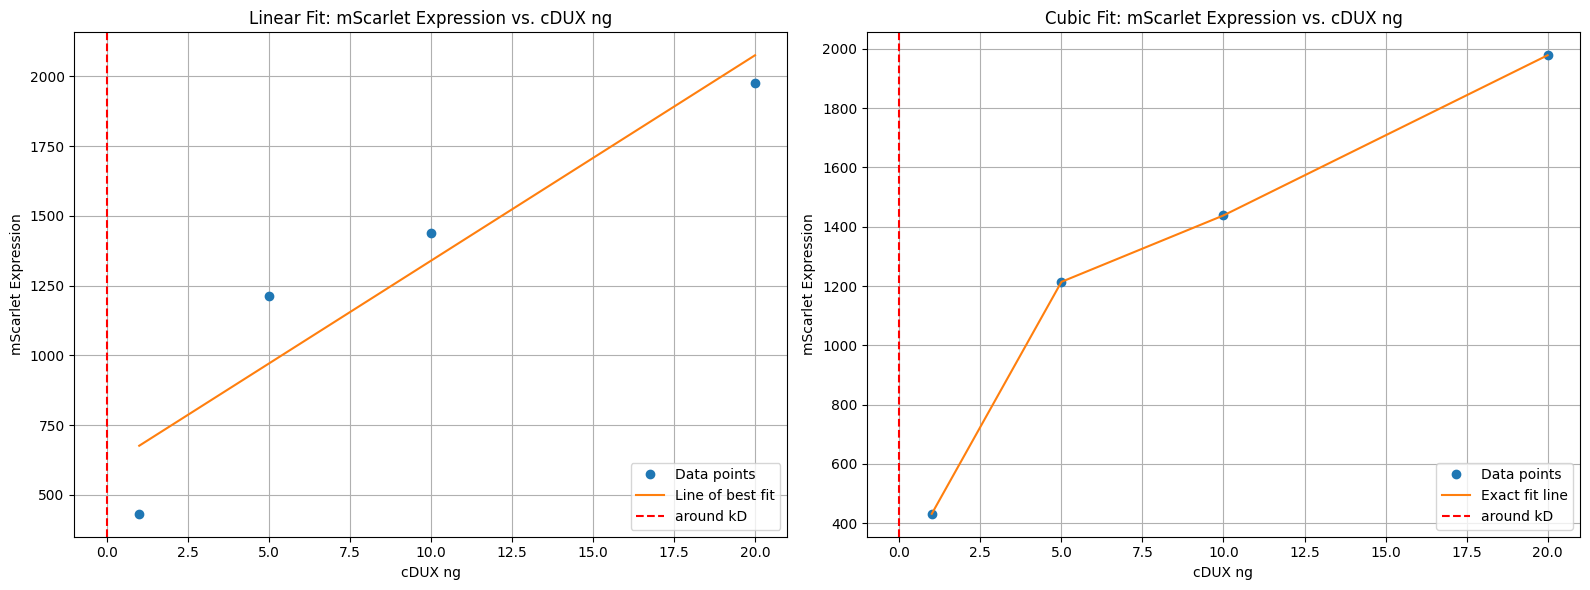

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data points
cDUX_ng = np.array([1, 5, 10, 20])
mScarlet_expression = np.array([432, 1214, 1438, 1978])

# Linear fit
coefficients = np.polyfit(cDUX_ng, mScarlet_expression, 1)
line_of_best_fit = np.polyval(coefficients, cDUX_ng)

# Cubic fit
coefficients_poly = np.polyfit(cDUX_ng, mScarlet_expression, 3)
line_of_best_fit_poly = np.polyval(coefficients_poly, cDUX_ng)

# Plotting the original linear fit and the exact cubic fit side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First plot: Linear fit
axes[0].plot(cDUX_ng, mScarlet_expression, 'o', label='Data points')
axes[0].plot(cDUX_ng, line_of_best_fit, '-', label='Line of best fit')
axes[0].axvline(x=0.0000014, color='red', linestyle='--', label='around kD')
axes[0].set_xlabel('cDUX ng')
axes[0].set_ylabel('mScarlet Expression')
axes[0].set_title('Linear Fit: mScarlet Expression vs. cDUX ng')
axes[0].legend()
axes[0].grid(True)

# Second plot: Exact cubic fit
axes[1].plot(cDUX_ng, mScarlet_expression, 'o', label='Data points')
axes[1].plot(cDUX_ng, line_of_best_fit_poly, '-', label='Exact fit line')
axes[1].axvline(x=0.0000014, color='red', linestyle='--', label='around kD')
axes[1].set_xlabel('cDUX ng')
axes[1].set_ylabel('mScarlet Expression')
axes[1].set_title('Cubic Fit: mScarlet Expression vs. cDUX ng')
axes[1].legend()
axes[1].grid(True)

# Show both plots
plt.tight_layout()
plt.show()

Normalized outputs for 1 binding sites and FL concentration 0.001: [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99999999e-01
 9.99999999e-01 9.99999998e-01 9.99999997e-01 9.99999995e-01
 9.99999992e-01 9.99999988e-01 9.99999980e-01 9.99999969e-01
 9.99999950e-01 9.99999921e-01 9.99999874e-01 9.99999799e-01
 9.99999680e-01 9.99999491e-01 9.99999189e-01 9.99998709e-01
 9.99997944e-01 9.99996727e-01 9.99994788e-01 9.99991701e-01
 9.99986786e-01 9.

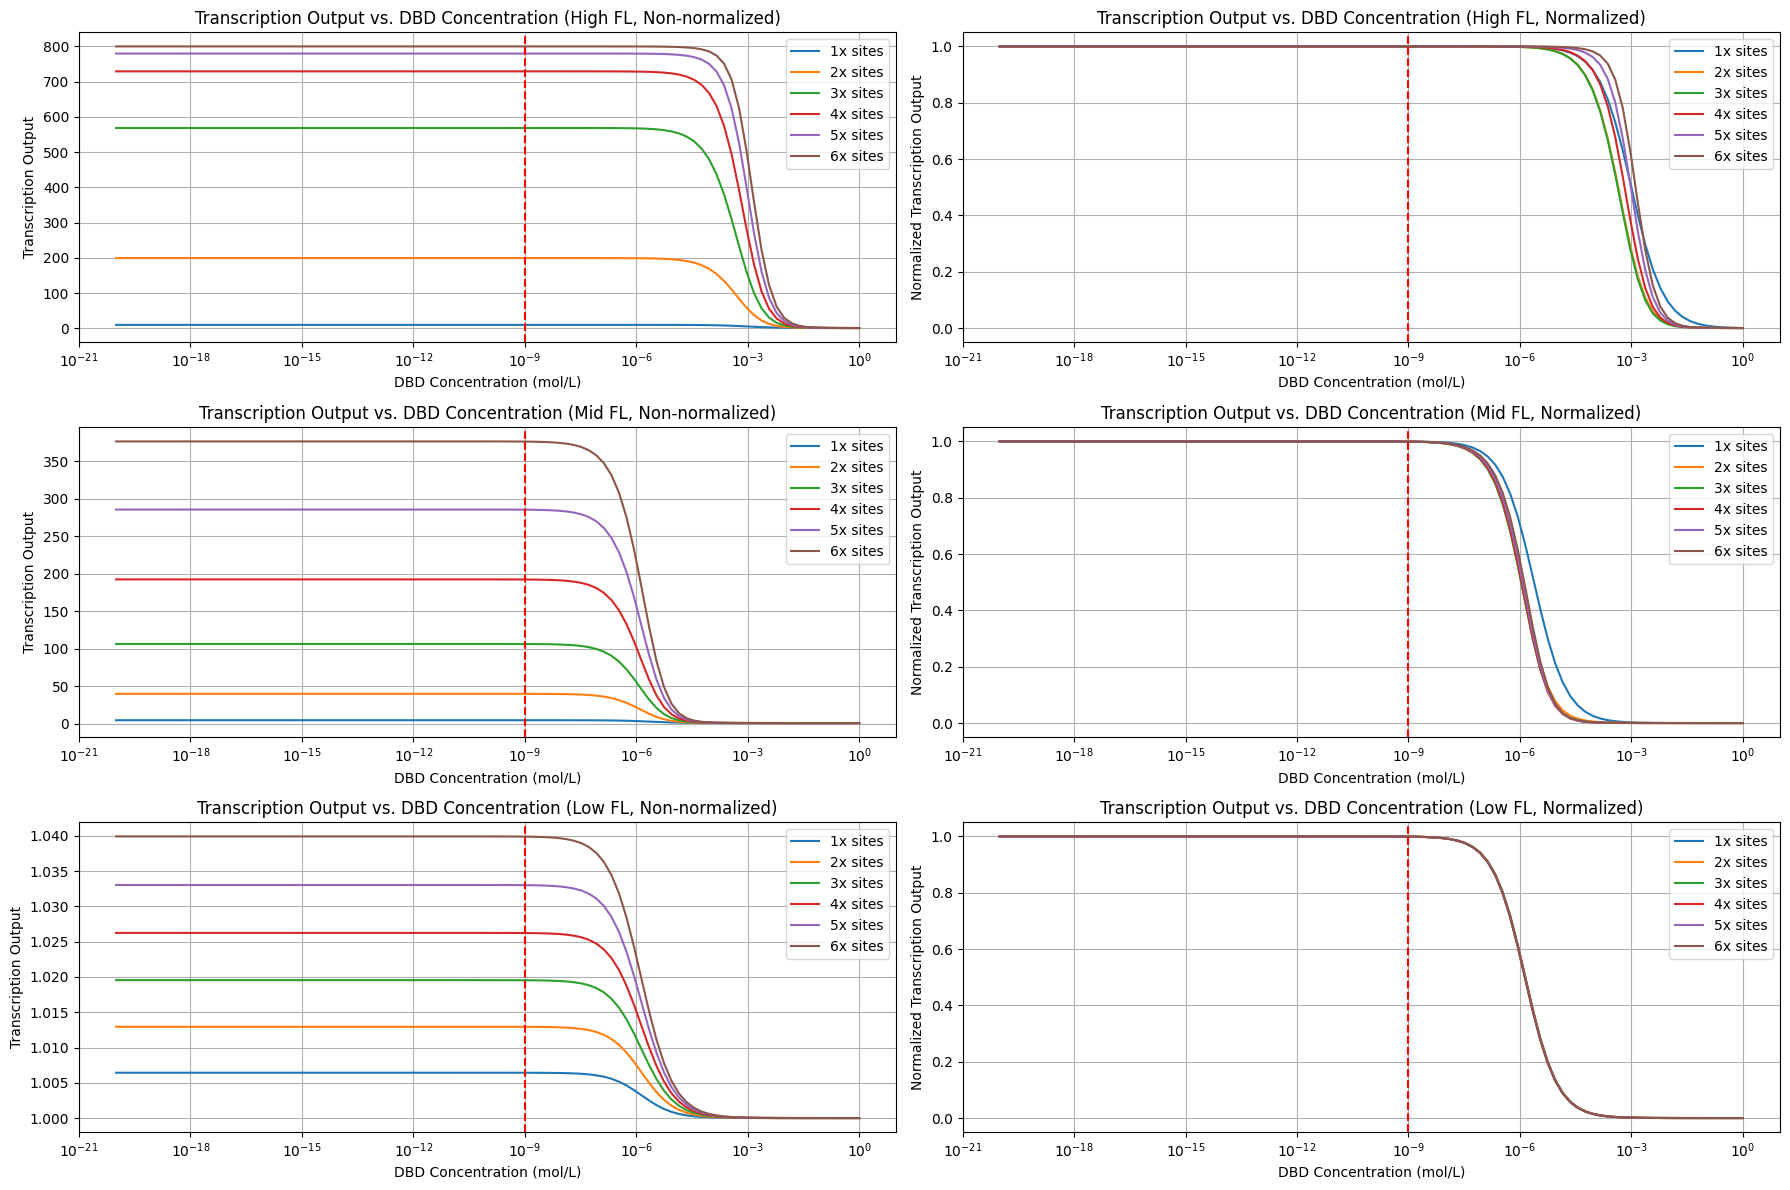

In [ ]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# Constants
kD = 0.0000014  # Dissociation constant
FL_concentration_high = 1e-3  # FL concentration >> kD
FL_concentration_mid = 1e-6   # FL concentration ~= kD
FL_concentration_low = 1e-9  # FL concentration << kD

# DBD_concentration extended up to 1000x higher, starting from 1e-10
DBD_concentration = np.logspace(np.log10(1e-20), np.log10(FL_concentration_high) + 3, 100)
num_sites_list = [1, 2, 3, 4, 5, 6]

# Synergy numbers based on the provided data points
synergy_numbers = {0: 1, 1: 10, 2: 200, 3: 570, 4: 730, 5: 780, 6: 800}

def binding_probability(TF1_conc, TF2_conc, kD):
    numerator = TF1_conc / kD
    denominator = 1 + (TF1_conc / kD) + (TF2_conc / kD)
    return numerator / denominator

def generate_binding_states(num_sites):
    """Generate all possible binding states for a given number of binding sites."""
    states = list(itertools.product([0, 1], repeat=num_sites))
    return states

def state_probability(state, FL_prob):
    """Calculate the probability of a specific binding state."""
    state_prob = 1
    for site in state:
        if site == 1:
            state_prob *= FL_prob  # FL binding probability
        else:
            state_prob *= (1 - FL_prob)  # No FL binding probability
    return state_prob

def transcription_output(FL_conc, DBD_conc, num_sites, kD):
    FL_prob = binding_probability(FL_conc, DBD_conc, kD)
    states = generate_binding_states(num_sites)
    total_output = 0
    for state in states:
        num_occupied_sites = sum(state)  # Count the number of occupied sites
        state_prob = state_probability(state, FL_prob)
        total_output += state_prob * synergy_numbers[num_occupied_sites]
    return total_output

# Adjusting normalization to be simpler
def calculate_outputs(FL_conc):
    outputs = {}
    normalized_outputs = {}
    table_outputs = []

    for sites in num_sites_list:
        output = []
        for DBD_conc in DBD_concentration:
            output.append(transcription_output(FL_conc, DBD_conc, sites, kD))
        outputs[sites] = np.array(output)
        max_output = outputs[sites][0]  # Assuming highest at lowest [DBD]
        min_output = outputs[sites][-1]  # Assuming lowest at highest [DBD]

        # Normalize so that it starts at 1 and tapers to 0
        normalized_outputs[sites] = (outputs[sites] - min_output) / (max_output - min_output)

        # Debug statements to check normalization
        print(f"Normalized outputs for {sites} binding sites and FL concentration {FL_conc}: {normalized_outputs[sites]}")
        print(f"First value (should be 1): {normalized_outputs[sites][0]}, Last value (should be 0): {normalized_outputs[sites][-1]}")

        table_outputs.append([sites, output[0]])

    return outputs, normalized_outputs, table_outputs


# Calculate outputs for different FL concentrations
outputs_high, normalized_outputs_high, table_outputs_high = calculate_outputs(FL_concentration_high)
outputs_mid, normalized_outputs_mid, table_outputs_mid = calculate_outputs(FL_concentration_mid)
outputs_low, normalized_outputs_low, table_outputs_low = calculate_outputs(FL_concentration_low)

# Convert table outputs to DataFrame
results_high = pd.DataFrame(table_outputs_high, columns=['Number of Binding Sites', 'Output'])
results_mid = pd.DataFrame(table_outputs_mid, columns=['Number of Binding Sites', 'Output'])
results_low = pd.DataFrame(table_outputs_low, columns=['Number of Binding Sites', 'Output'])
print("Results for high FL concentration:")
print(results_high)
print("\nResults for mid FL concentration:")
print(results_mid)
print("\nResults for low FL concentration:")
print(results_low)

# Plotting
plt.figure(figsize=(18, 12))

# Plot for high FL concentration
plt.subplot(3, 2, 1)
for sites in num_sites_list:
    plt.plot(DBD_concentration, outputs_high[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (High FL, Non-normalized)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 2)
for sites in num_sites_list:
    plt.plot(DBD_concentration, normalized_outputs_high[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (High FL, Normalized)')
plt.legend()
plt.grid(True)

# Plot for mid FL concentration
plt.subplot(3, 2, 3)
for sites in num_sites_list:
    plt.plot(DBD_concentration, outputs_mid[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Mid FL, Non-normalized)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 4)
for sites in num_sites_list:
    plt.plot(DBD_concentration, normalized_outputs_mid[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Mid FL, Normalized)')
plt.legend()
plt.grid(True)

# Plot for low FL concentration
plt.subplot(3, 2, 5)
for sites in num_sites_list:
    plt.plot(DBD_concentration, outputs_low[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Low FL, Non-normalized)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 6)
for sites in num_sites_list:
    plt.plot(DBD_concentration, normalized_outputs_low[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Low FL, Normalized)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


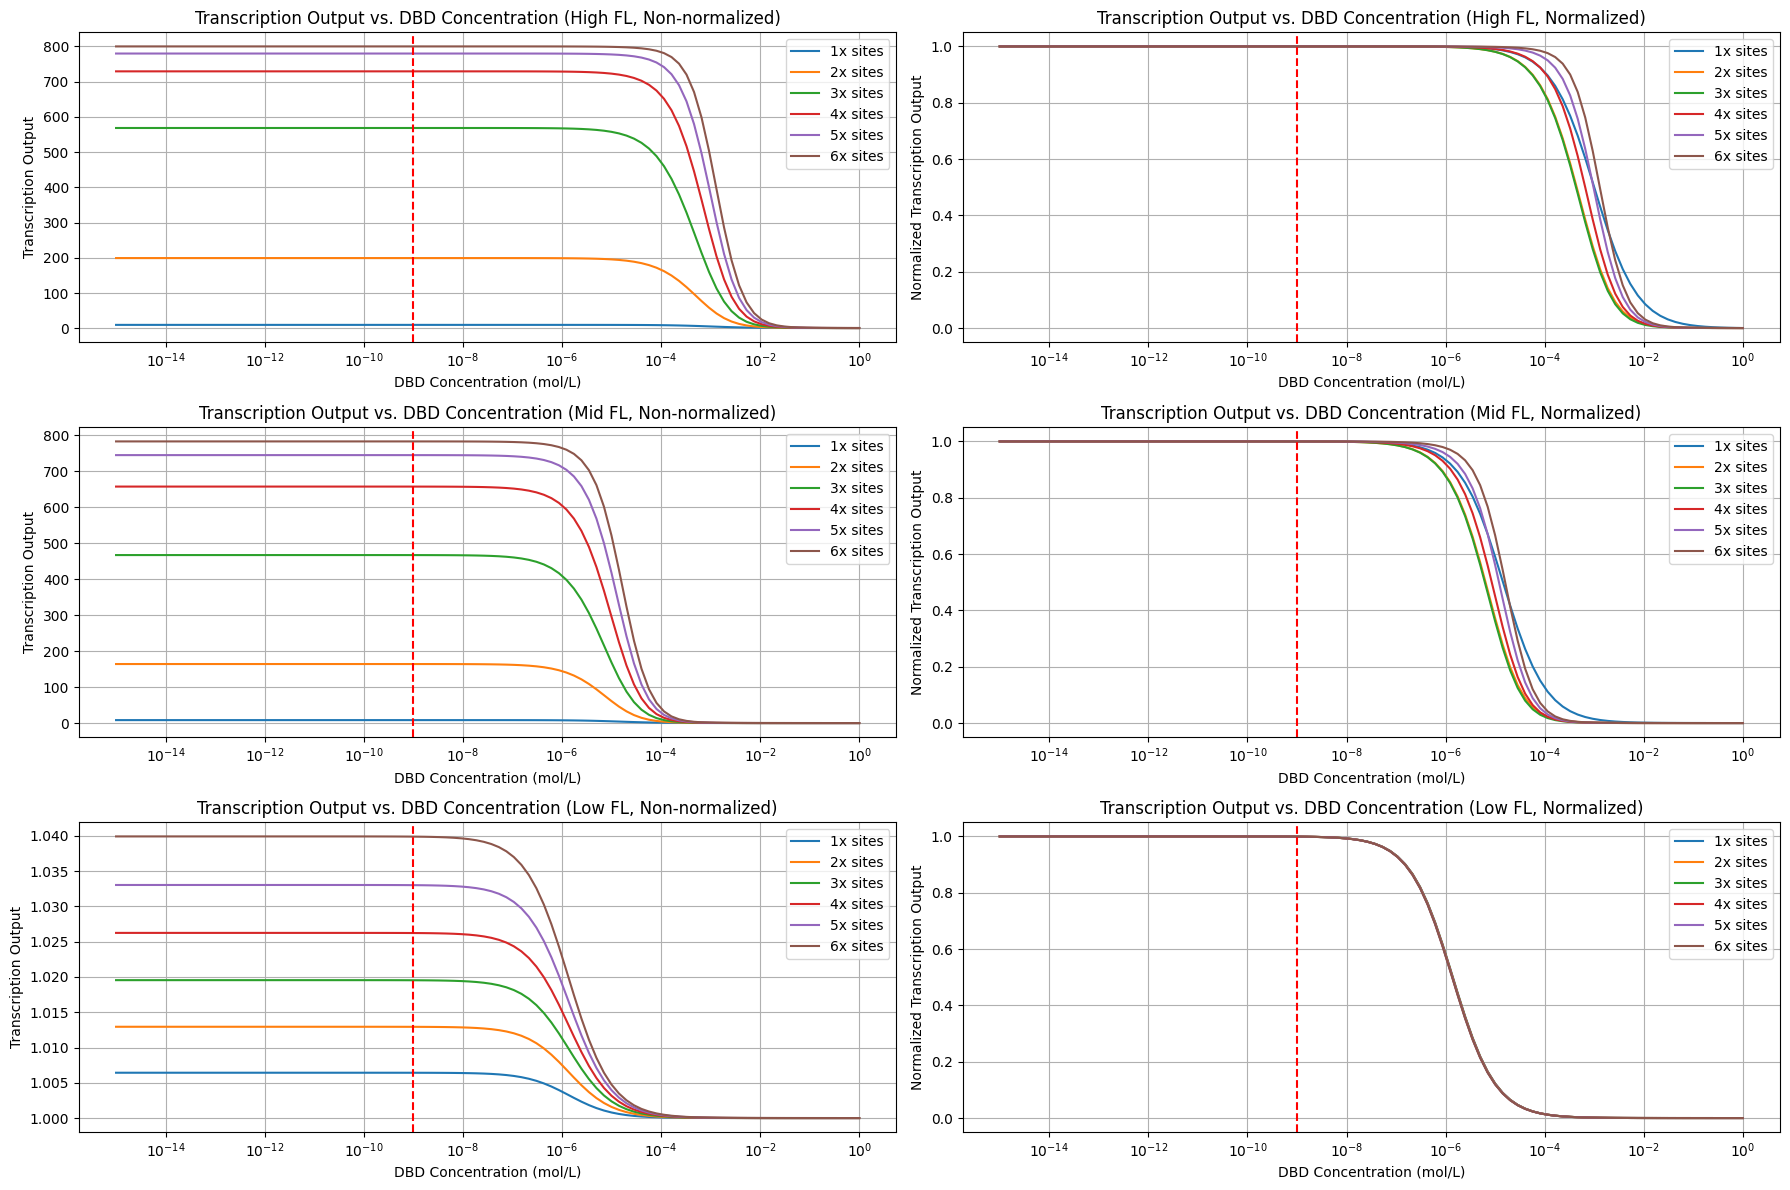

In [ ]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# Constants
kD = 0.0000014  # Dissociation constant
FL_concentration_high = 1e-3  # FL concentration >> kD
FL_concentration_mid = 0.000013  # FL concentration ~= kD
FL_concentration_low = 1e-9  # FL concentration << kD

# DBD_concentration extended up to 1000x higher, starting from 1e-15
DBD_concentration = np.logspace(np.log10(1e-15), np.log10(FL_concentration_high) + 3, 100)
num_sites_list = [1, 2, 3, 4, 5, 6]

# Synergy numbers based on the provided data points
synergy_numbers = {0: 1, 1: 10, 2: 200, 3: 570, 4: 730, 5: 780, 6: 800}

def binding_probability(TF1_conc, TF2_conc, kD):
    numerator = TF1_conc / kD
    denominator = 1 + (TF1_conc / kD) + (TF2_conc / kD)
    return numerator / denominator

def generate_binding_states(num_sites):
    """Generate all possible binding states for a given number of binding sites."""
    states = list(itertools.product([0, 1], repeat=num_sites))
    return states

def state_probability(state, FL_prob):
    """Calculate the probability of a specific binding state."""
    state_prob = 1
    for site in state:
        if site == 1:
            state_prob *= FL_prob  # FL binding probability
        else:
            state_prob *= (1 - FL_prob)  # No FL binding probability
    return state_prob

def transcription_output(FL_conc, DBD_conc, num_sites, kD):
    FL_prob = binding_probability(FL_conc, DBD_conc, kD)
    states = generate_binding_states(num_sites)
    total_output = 0
    for state in states:
        num_occupied_sites = sum(state)  # Count the number of occupied sites
        state_prob = state_probability(state, FL_prob)
        total_output += state_prob * synergy_numbers[num_occupied_sites]
    return total_output

def calculate_outputs(FL_conc):
    outputs = {}
    normalized_outputs = {}
    table_outputs = []

    for sites in num_sites_list:
        output = []
        for DBD_conc in DBD_concentration:
            output.append(transcription_output(FL_conc, DBD_conc, sites, kD))
        outputs[sites] = np.array(output)
        max_output = outputs[sites][0]  # Maximum output is when [DBD] = 0
        min_output = outputs[sites][-1]  # Minimum output is when [DBD] is highest

        # Normalize so that it starts at 1 and tapers to 0
        normalized_outputs[sites] = (outputs[sites] - min_output) / (max_output - min_output)
        normalized_outputs[sites] = (normalized_outputs[sites] - normalized_outputs[sites][-1]) / (normalized_outputs[sites][0] - normalized_outputs[sites][-1])  # Ensure starts at 1

        table_outputs.append([sites, output[0]])

    return outputs, normalized_outputs, table_outputs

# Calculate outputs for different FL concentrations
outputs_high, normalized_outputs_high, table_outputs_high = calculate_outputs(FL_concentration_high)
outputs_mid, normalized_outputs_mid, table_outputs_mid = calculate_outputs(FL_concentration_mid)
outputs_low, normalized_outputs_low, table_outputs_low = calculate_outputs(FL_concentration_low)

# Convert table outputs to DataFrame
results_high = pd.DataFrame(table_outputs_high, columns=['Number of Binding Sites', 'Output'])
results_mid = pd.DataFrame(table_outputs_mid, columns=['Number of Binding Sites', 'Output'])
results_low = pd.DataFrame(table_outputs_low, columns=['Number of Binding Sites', 'Output'])

# Plotting
plt.figure(figsize=(18, 12))

# Plot for high FL concentration
plt.subplot(3, 2, 1)
for sites in num_sites_list:
    plt.plot(DBD_concentration, outputs_high[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (High FL, Non-normalized)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 2)
for sites in num_sites_list:
    plt.plot(DBD_concentration, normalized_outputs_high[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (High FL, Normalized)')
plt.legend()
plt.grid(True)

# Plot for mid FL concentration
plt.subplot(3, 2, 3)
for sites in num_sites_list:
    plt.plot(DBD_concentration, outputs_mid[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Mid FL, Non-normalized)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 4)
for sites in num_sites_list:
    plt.plot(DBD_concentration, normalized_outputs_mid[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Mid FL, Normalized)')
plt.legend()
plt.grid(True)

# Plot for low FL concentration
plt.subplot(3, 2, 5)
for sites in num_sites_list:
    plt.plot(DBD_concentration, outputs_low[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Low FL, Non-normalized)')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 6)
for sites in num_sites_list:
    plt.plot(DBD_concentration, normalized_outputs_low[sites], label=f"{sites}x sites")
plt.axvline(1e-9, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('DBD Concentration (mol/L)')
plt.ylabel('Normalized Transcription Output')
plt.title('Transcription Output vs. DBD Concentration (Low FL, Normalized)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
def find_inhibition_concentration(normalized_outputs, inhibition_level):
    """Find the DBD concentration needed to achieve the desired inhibition level."""
    target_output = 1 - inhibition_level  # e.g., 0.02 for 98% inhibition
    inhibition_concentrations = {}

    for sites in num_sites_list:
        # Interpolating to find the DBD concentration at the desired inhibition level
        try:
            idx = np.where(normalized_outputs[sites] <= target_output)[0][0]
            inhibition_concentration = DBD_concentration[idx]
        except IndexError:
            inhibition_concentration = None  # In case the inhibition level is not reached

        inhibition_concentrations[sites] = inhibition_concentration

    return inhibition_concentrations

# Target inhibition levels
inhibition_levels = [0.98, 0.999]  # 98% and 99.9% inhibition

# Calculate the DBD concentrations for the target inhibition levels
inhibition_concentration_high = {level: find_inhibition_concentration(normalized_outputs_high, level) for level in inhibition_levels}
inhibition_concentration_mid = {level: find_inhibition_concentration(normalized_outputs_mid, level) for level in inhibition_levels}
inhibition_concentration_low = {level: find_inhibition_concentration(normalized_outputs_low, level) for level in inhibition_levels}

# Create a DataFrame for displaying results
results_df = pd.DataFrame({
    "Inhibition Level": [f"{level * 100}%" for level in inhibition_levels],
    "High FL Concentration": [inhibition_concentration_high[level] for level in inhibition_levels],
    "Mid FL Concentration": [inhibition_concentration_mid[level] for level in inhibition_levels],
    "Low FL Concentration": [inhibition_concentration_low[level] for level in inhibition_levels]
})

# Display the results
print(results_df)


  Inhibition Level                              High FL Concentration  \
0            98.0%  {1: 0.06135907273413188, 2: 0.0107226722201032...   
1            99.9%  {1: 0.705480231071866, 2: 0.12328467394420685,...   

                                Mid FL Concentration  \
0  {1: 0.0009326033468832219, 2: 0.00016297508346...   
1  {1: 0.01519911082952933, 2: 0.0018738174228603...   

                                Low FL Concentration  
0  {1: 8.11130830789689e-05, 2: 8.11130830789689e...  
1  {1: 0.0018738174228603867, 2: 0.00187381742286...  


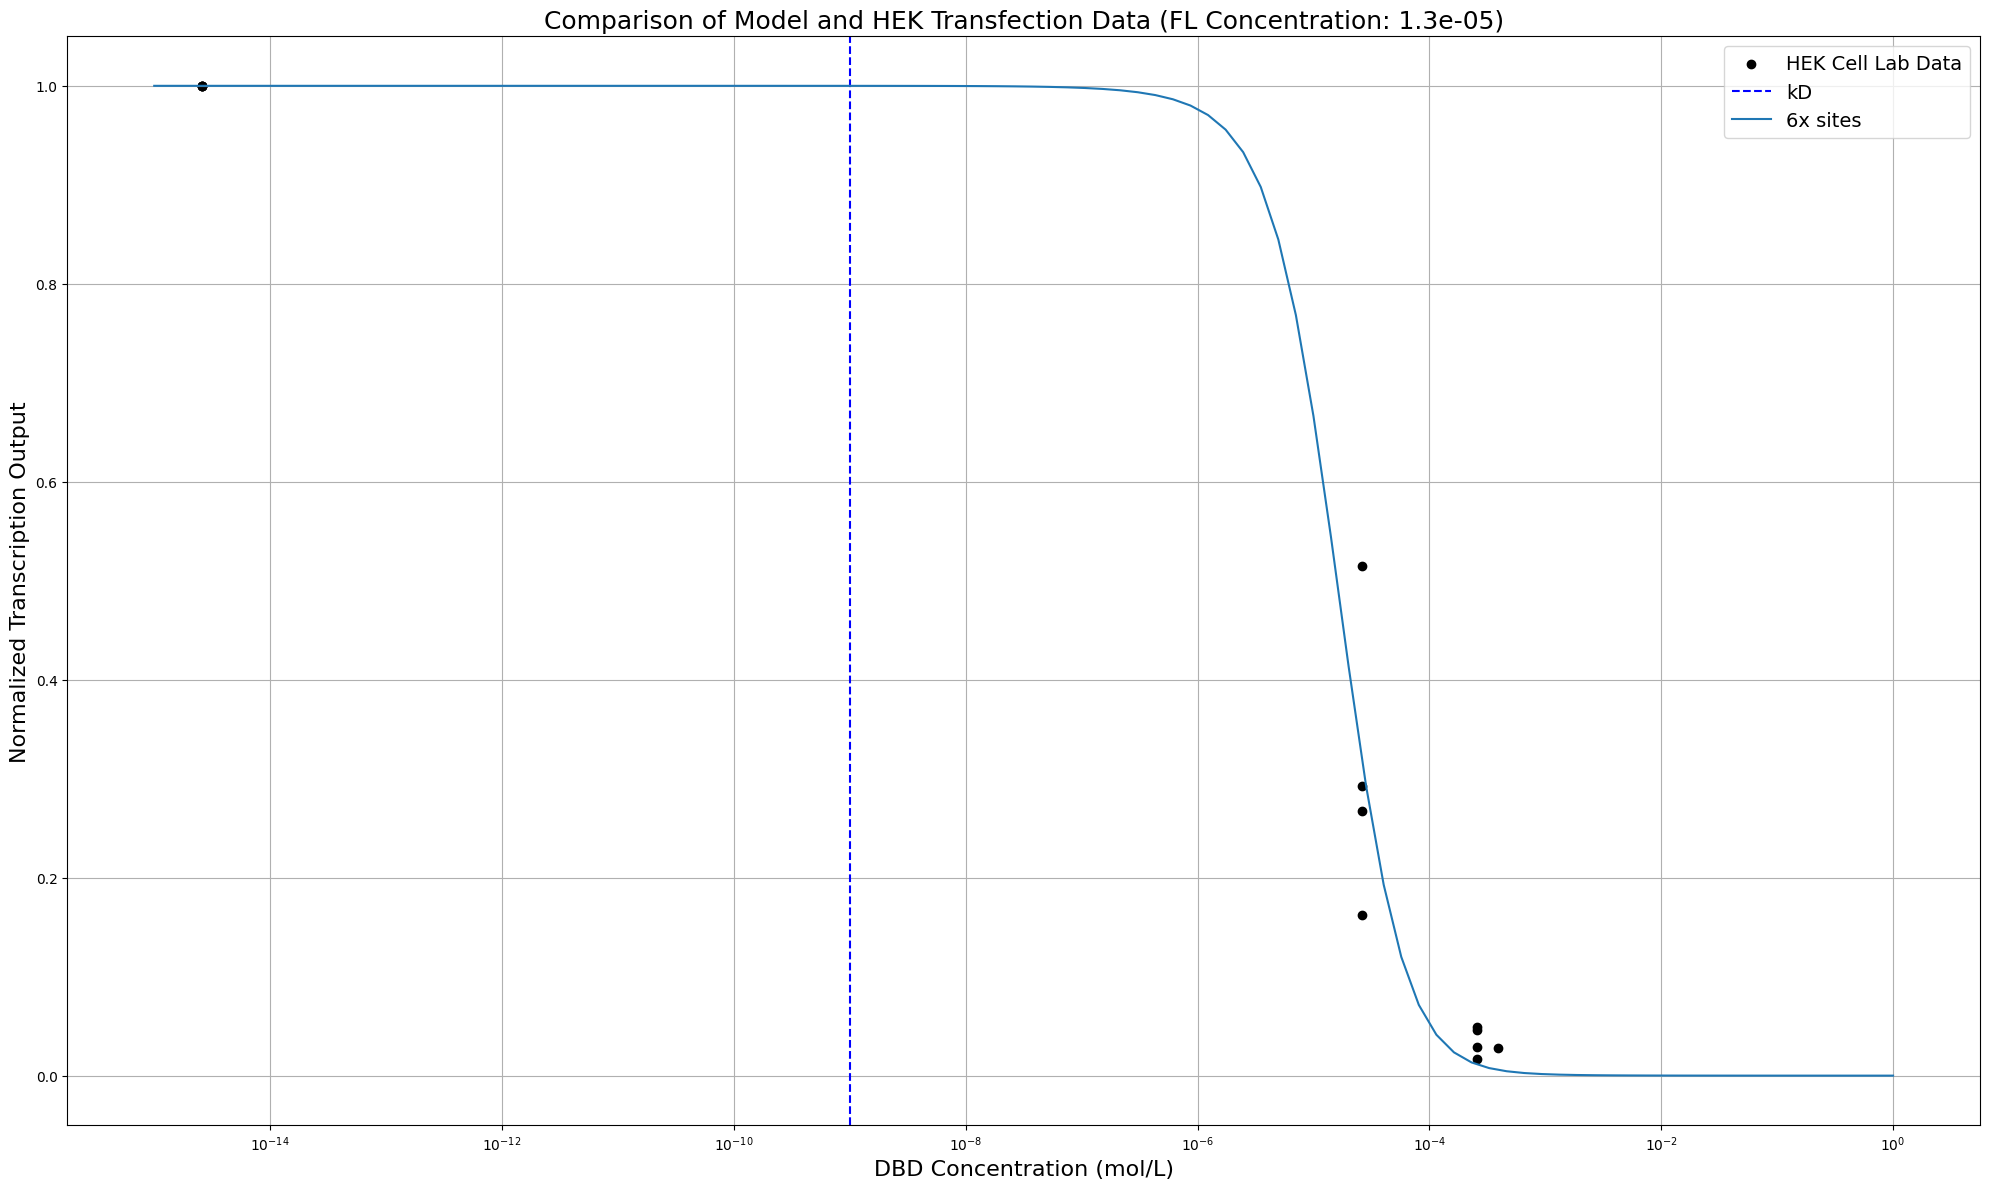

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Given data
FL_concentration = 0.000013

p21_data = {
    'dbd': [1e-10, 1, 10],
    'p21_data': [472, 138, 23],
}

p22_data = {
    'dbd': [1e-10, 1, 10, 15],
    'p22_data': [832, 428, 38, 23],
}

p23_data = {
    'dbd': [1e-10, 1, 10],
    'p23_data': [2090, 340, 36],
}

avg_data = {
    'dbd': [1e-10, 1, 10],
    'avg_data': [1131.3, 302, 32.3],
}

# Convert to DataFrames
df_p21 = pd.DataFrame(p21_data)
df_p22 = pd.DataFrame(p22_data)
df_p23 = pd.DataFrame(p23_data)
df_avg = pd.DataFrame(avg_data)

# Normalize the data by dividing by 1131.3 (max activation = 1)
df_p21['p21_normalized'] = df_p21['p21_data'] / 472
df_p22['p22_normalized'] = df_p22['p22_data'] / 832
df_p23['p23_normalized'] = df_p23['p23_data'] / 2090
df_avg['avg_normalized'] = df_avg['avg_data'] / 1131.3

# Corresponding DBD concentrations for the ratios in the data, because of the different promoters
df_p21['dbd_conc'] = df_p21['dbd'] * FL_concentration * 2
df_p22['dbd_conc'] = df_p22['dbd'] * FL_concentration * 2
df_p23['dbd_conc'] = df_p23['dbd'] * FL_concentration * 2
df_avg['dbd_conc'] = df_avg['dbd'] * FL_concentration * 2

# Plotting the data along with the model
plt.figure(figsize=(20, 12))

# Plot the normalized data as points with the same color
plt.scatter(df_p21['dbd_conc'], df_p21['p21_normalized'], color='black', label='HEK Cell Lab Data')
plt.scatter(df_p22['dbd_conc'], df_p22['p22_normalized'], color='black')
plt.scatter(df_p23['dbd_conc'], df_p23['p23_normalized'], color='black')
plt.scatter(df_avg['dbd_conc'], df_avg['avg_normalized'], color='black')

# Adding a vertical line at kD (1e-9) for reference and label it as kD
plt.axvline(1e-9, color='b', linestyle='--', label='kD')

# Set x-axis to log scale
plt.xscale('log')

# MODEL PLOT
# Assuming DBD_concentration and normalized_outputs_mid are already defined elsewhere in your code
plt.plot(DBD_concentration, normalized_outputs_mid[6], label=f"{sites}x sites")

# Labels and title
plt.xlabel('DBD Concentration (mol/L)', fontsize=16)
plt.ylabel('Normalized Transcription Output', fontsize=16)
plt.title(f'Comparison of Model and HEK Transfection Data (FL Concentration: {FL_concentration})', fontsize=18)

# Grid and legend
plt.grid(True)
plt.legend(fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()
